<a href="https://colab.research.google.com/github/seeedata/BADA/blob/main/BADATON/%EC%83%9D%ED%99%9C%EC%9D%B4%EB%8F%99%20%EB%B6%84%EC%82%B0%EB%B6%84%EC%84%9D%2C%20%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'NanumBarunGothic'
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import bartlett
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import MultiComparison

#데이터 불러오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BADA/바다톤/data/생활이동_통합_데이터.csv')
df

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수
0,00:00:00,2022-12-01,금,11010,11110,F,20대,EH,225.18
1,00:00:00,2022-12-01,금,11010,11110,F,20대,HH,1.50
2,00:00:00,2022-12-01,금,11010,11110,F,20대,WH,175.66
3,00:00:00,2022-12-01,금,11010,11110,F,30대,EH,91.37
4,00:00:00,2022-12-01,금,11010,11110,F,30대,WH,79.61
...,...,...,...,...,...,...,...,...,...
1937819,23:00:00,2023-03-01,화,39000,11240,M,30대,EH,10.97
1937820,23:00:00,2023-03-01,화,39000,11240,M,40대,EH,31.03
1937821,23:00:00,2023-03-01,화,39000,11240,M,50대,EH,3.28
1937822,23:00:00,2023-03-01,화,39000,11240,M,60대,EH,3.49


In [ ]:
code_list = [
    11010, 11020, 11030, 11040, 11050, 11060, 11070, 11080, 11090,
    11100, 11110, 11120, 11130, 11140, 11150, 11160, 11170, 11180,
    11190, 11200, 11210, 11220, 11230, 11240, 11250
    ]
df = df[df['출발 시군구 코드'].isin(code_list)]

df.reset_index(drop=True, inplace=True)

df['대상연월'] = df['대상연월'].map({'2022-12-01':0, '2023-01-01':1, '2023-02-01':2, '2023-03-01':3})
df['요일'] = df['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4, '토':5, '일':6})
df['출발 시군구 코드'] = df['출발 시군구 코드'].map({11010: 0, 11020: 1, 11030: 2, 11040: 3, 11050: 4, 11060: 5, 11070: 6, 11080: 7,
                                                     11090: 8, 11100: 9, 11110: 10, 11120: 11, 11130: 12, 11140: 13, 11150: 14,
                                                     11160: 15, 11170: 16, 11180: 17, 11190: 18, 11200: 19, 11210: 20, 11220: 21,
                                                     11230: 22, 11240: 23, 11250: 24})
df['도착 시군구 코드'] = df['도착 시군구 코드'].map({11110: 0, 11160: 1, 11210: 2, 11230: 3, 11240: 4})
df['성별'] = df['성별'].map({'M':0, 'F': 1})
df['이동유형'] = df['이동유형'].map({'EH': 0, 'HH': 1, 'WH': 2})
df['나이대'] = df['나이대'].map({'20대': 0, '30대': 1, '40대': 2, '50대': 3, '60대': 4, '70대': 5, '80대': 6})
df['귀가시간대'] = df['귀가시간대'].map({'00:00:00': 0, '01:00:00': 1, '02:00:00': 2, '03:00:00': 3, '04:00:00': 4,
                               '18:00:00': 5, '19:00:00': 6, '20:00:00': 7, '21:00:00': 8, '22:00:00': 9, '23:00:00': 10})
df

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수
0,0,0,4,0,0,1,0,0,225.18
1,0,0,4,0,0,1,0,1,1.50
2,0,0,4,0,0,1,0,2,175.66
3,0,0,4,0,0,1,1,0,91.37
4,0,0,4,0,0,1,1,2,79.61
...,...,...,...,...,...,...,...,...,...
849620,10,3,1,24,4,0,4,1,3.52
849621,10,3,1,24,4,0,4,2,137.66
849622,10,3,1,24,4,0,5,0,72.09
849623,10,3,1,24,4,0,5,2,42.98


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849625 entries, 0 to 849624
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   귀가시간대      849625 non-null  int64  
 1   대상연월       849625 non-null  int64  
 2   요일         849625 non-null  int64  
 3   출발 시군구 코드  849625 non-null  int64  
 4   도착 시군구 코드  849625 non-null  int64  
 5   성별         849625 non-null  int64  
 6   나이대        849625 non-null  int64  
 7   이동유형       849625 non-null  int64  
 8   이동인구수      849625 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 58.3 MB


#로그 변환

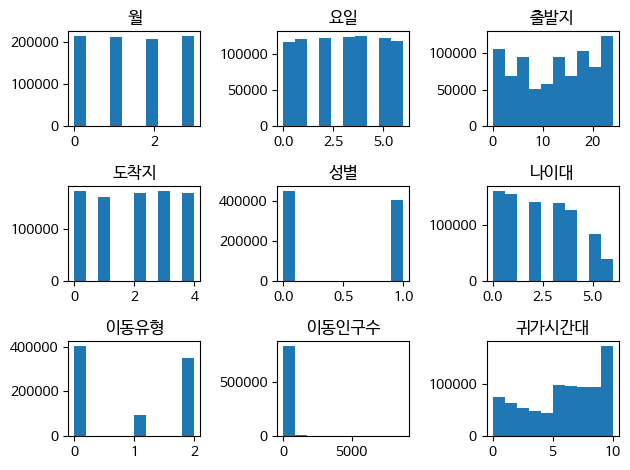

In [ ]:
plt.subplot(3,3,1)
plt.hist(df['대상연월'])
plt.title('월')

plt.subplot(3,3,2)
plt.hist(df['요일'])
plt.title('요일')

plt.subplot(3,3,3)
plt.hist(df['출발 시군구 코드'])
plt.title('출발지')

plt.subplot(3,3,4)
plt.hist(df['도착 시군구 코드'])
plt.title('도착지')

plt.subplot(3,3,5)
plt.hist(df['성별'])
plt.title('성별')

plt.subplot(3,3,6)
plt.hist(df['나이대'])
plt.title('나이대')

plt.subplot(3,3,7)
plt.hist(df['이동유형'])
plt.title('이동유형')

plt.subplot(3,3,8)
plt.hist(df['이동인구수'])
plt.title('이동인구수')

plt.subplot(3,3,9)
plt.hist(df['귀가시간대'])
plt.title('귀가시간대')

plt.tight_layout()
plt.show()

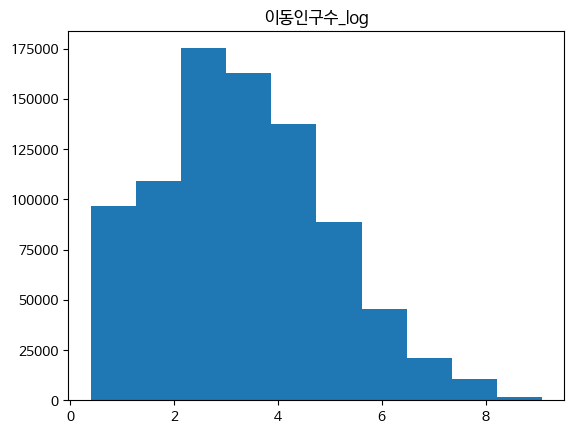

In [ ]:
#이동인구수 로그 변환
df['이동인구수_log'] = np.log(df['이동인구수'])
plt.hist(df['이동인구수_log'])
plt.title('이동인구수_log')
plt.show()

#상관계수

In [ ]:
corr = df.corr()
corr

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수,이동인구수_log
귀가시간대,1.000000,0.002487,-0.019263,-0.016186,0.003002,0.028956,0.068118,0.017102,0.089533,0.202195
대상연월,0.002487,1.000000,-0.002305,-0.000138,-0.000007,-0.001516,0.003164,0.003316,0.011786,0.007786
요일,-0.019263,-0.002305,1.000000,-0.000990,-0.001316,0.002384,-0.010451,-0.026873,-0.038708,-0.052345
출발 시군구 코드,-0.016186,-0.000138,-0.000990,1.000000,0.062233,0.007317,0.022895,0.006472,0.175970,0.157213
도착 시군구 코드,0.003002,-0.000007,-0.001316,0.062233,1.000000,-0.000104,-0.006177,0.002520,0.040751,-0.010153
성별,0.028956,-0.001516,0.002384,0.007317,-0.000104,1.000000,-0.018509,0.000241,0.022814,0.011359
나이대,0.068118,0.003164,-0.010451,0.022895,-0.006177,-0.018509,1.000000,-0.030376,-0.051845,0.013298
이동유형,0.017102,0.003316,-0.026873,0.006472,0.002520,0.000241,-0.030376,1.000000,0.024067,0.021748
이동인구수,0.089533,0.011786,-0.038708,0.175970,0.040751,0.022814,-0.051845,0.024067,1.000000,0.594163
이동인구수_log,0.202195,0.007786,-0.052345,0.157213,-0.010153,0.011359,0.013298,0.021748,0.594163,1.000000


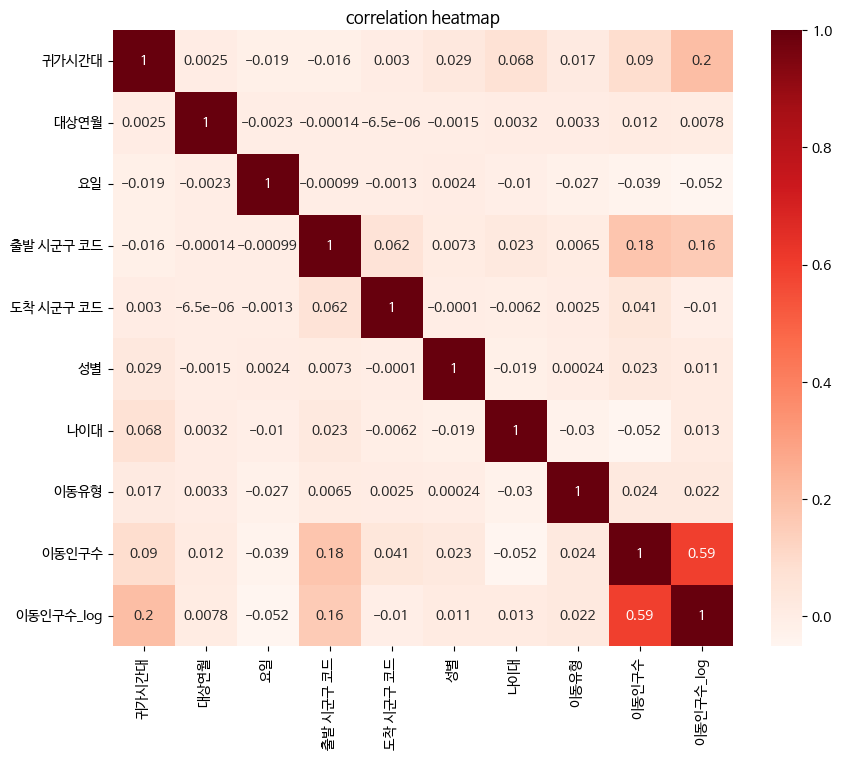

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Reds', annot=True)
plt.title('correlation heatmap')
plt.show()

✅ 선형 회귀는 효과가 없을 것 같다. 비선형 모델 사용하자.


#<대상연월, 요일, 성별, 귀가시간대, 나이대>와 <이동인구수>간 관계



In [ ]:
X = df[['대상연월', '요일', '성별', '귀가시간대']]
y = df['이동인구수_log']

In [ ]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
X_with_intercept = sm.add_constant(X)

model = sm.OLS(y, X_with_intercept)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              이동인구수_log   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     9617.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        04:20:14   Log-Likelihood:            -1.6082e+06
No. Observations:              849625   AIC:                         3.216e+06
Df Residuals:                  849620   BIC:                         3.216e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8724      0.005    547.605      0.0

✅ 결정계수가 너무 작다.

#월별 데이터 분류

In [ ]:
df.head(2)

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수,이동인구수_log
0,0,0,4,0,0,1,0,0,225.18,5.416900
1,0,0,4,0,0,1,0,1,1.50,0.405465


In [ ]:
df_12월 = df[df['대상연월']==0]
df_1월 = df[df['대상연월']==1]
df_2월 = df[df['대상연월']==2]
df_3월 = df[df['대상연월']==3]

#월별+시간대별 데이터 분류

In [ ]:
df_12월_0시 = df_12월[df_12월['귀가시간대']==0]
df_12월_1시 = df_12월[df_12월['귀가시간대']==1]
df_12월_2시 = df_12월[df_12월['귀가시간대']==2]
df_12월_3시 = df_12월[df_12월['귀가시간대']==3]
df_12월_4시 = df_12월[df_12월['귀가시간대']==4]
df_12월_18시 = df_12월[df_12월['귀가시간대']==5]
df_12월_19시 = df_12월[df_12월['귀가시간대']==6]
df_12월_20시 = df_12월[df_12월['귀가시간대']==7]
df_12월_21시 = df_12월[df_12월['귀가시간대']==8]
df_12월_22시 = df_12월[df_12월['귀가시간대']==9]
df_12월_23시 = df_12월[df_12월['귀가시간대']==10]

df_1월_0시 = df_1월[df_1월['귀가시간대']==0]
df_1월_1시 = df_1월[df_1월['귀가시간대']==1]
df_1월_2시 = df_1월[df_1월['귀가시간대']==2]
df_1월_3시 = df_1월[df_1월['귀가시간대']==3]
df_1월_4시 = df_1월[df_1월['귀가시간대']==4]
df_1월_18시 = df_1월[df_1월['귀가시간대']==5]
df_1월_19시 = df_1월[df_1월['귀가시간대']==6]
df_1월_20시 = df_1월[df_1월['귀가시간대']==7]
df_1월_21시 = df_1월[df_1월['귀가시간대']==8]
df_1월_22시 = df_1월[df_1월['귀가시간대']==9]
df_1월_23시 = df_1월[df_1월['귀가시간대']==10]

df_2월_0시 = df_2월[df_2월['귀가시간대']==0]
df_2월_1시 = df_2월[df_2월['귀가시간대']==1]
df_2월_2시 = df_2월[df_2월['귀가시간대']==2]
df_2월_3시 = df_2월[df_2월['귀가시간대']==3]
df_2월_4시 = df_2월[df_2월['귀가시간대']==4]
df_2월_18시 = df_2월[df_2월['귀가시간대']==5]
df_2월_19시 = df_2월[df_2월['귀가시간대']==6]
df_2월_20시 = df_2월[df_2월['귀가시간대']==7]
df_2월_21시 = df_2월[df_2월['귀가시간대']==8]
df_2월_22시 = df_2월[df_2월['귀가시간대']==9]
df_2월_23시 = df_2월[df_2월['귀가시간대']==10]

df_3월_0시 = df_3월[df_3월['귀가시간대']==0]
df_3월_1시 = df_3월[df_3월['귀가시간대']==1]
df_3월_2시 = df_3월[df_3월['귀가시간대']==2]
df_3월_3시 = df_3월[df_3월['귀가시간대']==3]
df_3월_4시 = df_3월[df_3월['귀가시간대']==4]
df_3월_18시 = df_3월[df_3월['귀가시간대']==5]
df_3월_19시 = df_3월[df_3월['귀가시간대']==6]
df_3월_20시 = df_3월[df_3월['귀가시간대']==7]
df_3월_21시 = df_3월[df_3월['귀가시간대']==8]
df_3월_22시 = df_3월[df_3월['귀가시간대']==9]
df_3월_23시 = df_3월[df_3월['귀가시간대']==10]

# 분산분석

- 택시비 인상이 이동인구 수에 영향을 미칠 것이다.

- 각 시간대를 x, 이동인구 수를 y로 해서 그래프 그리기 → 월별 비교


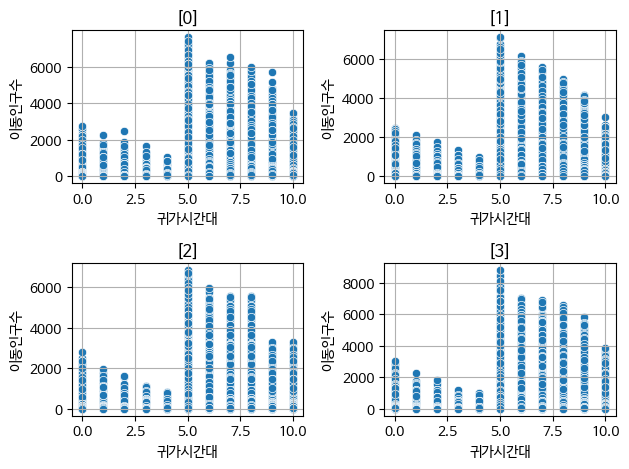

In [ ]:
for index, df_month in enumerate([df_12월, df_1월, df_2월, df_3월]):
    plt.subplot(2, 2, index+1)
    sns.scatterplot(x='귀가시간대', y='이동인구수', data=df_month)
    plt.title(df_month['대상연월'].unique())
    plt.grid(True)

plt.tight_layout()
plt.show()

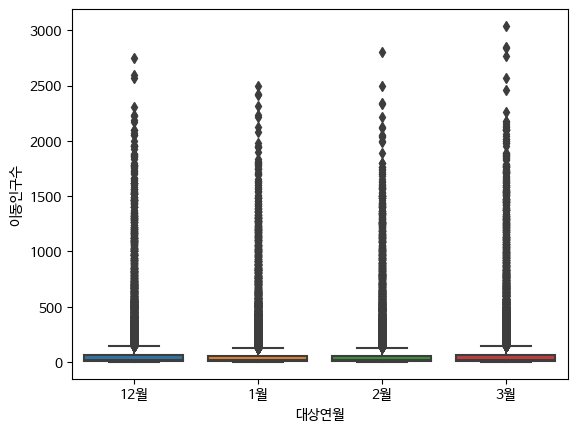

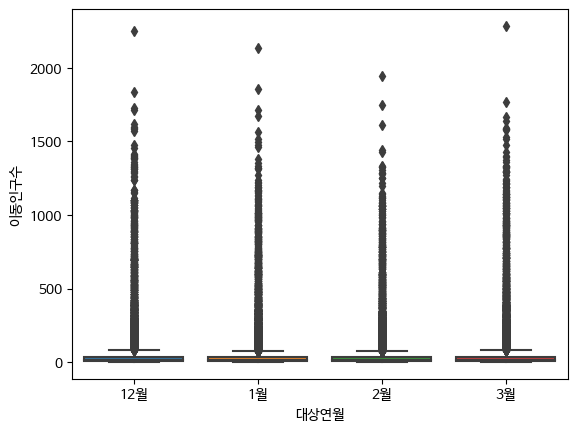

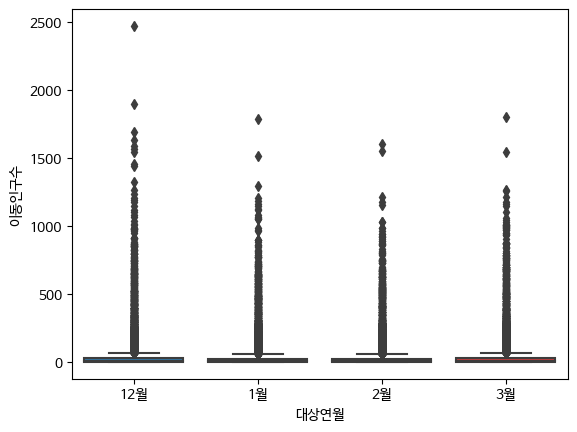

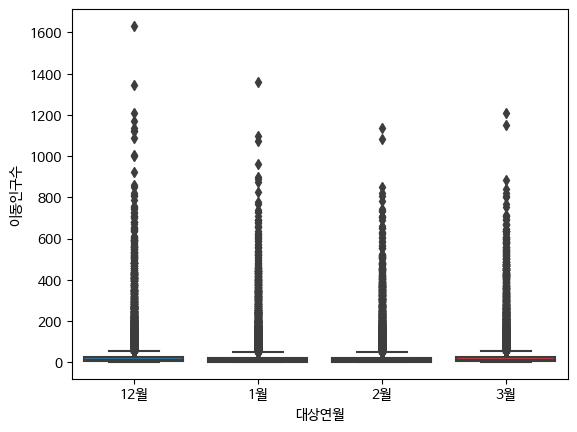

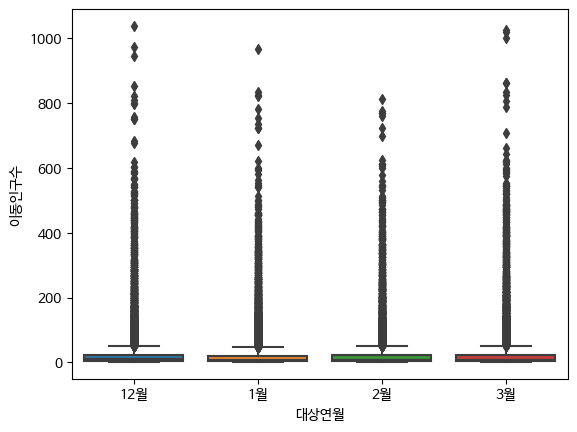

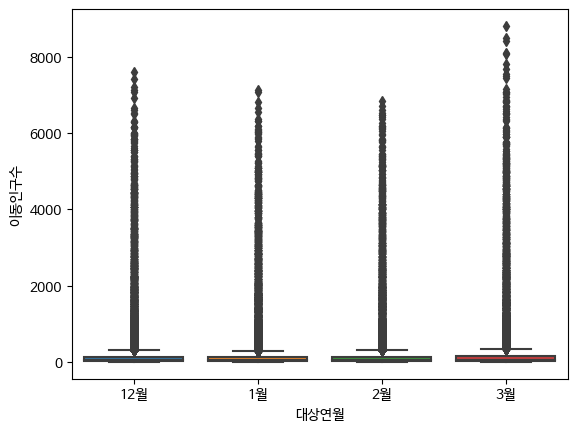

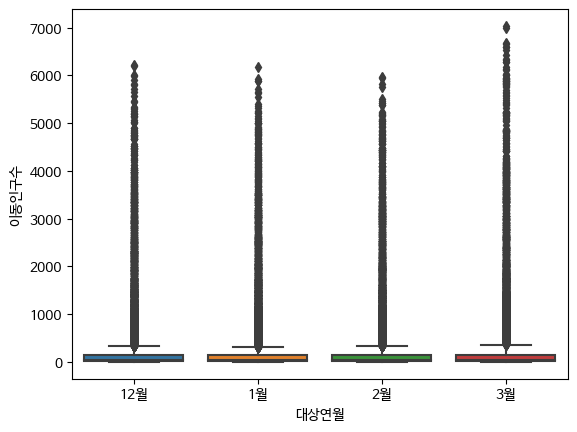

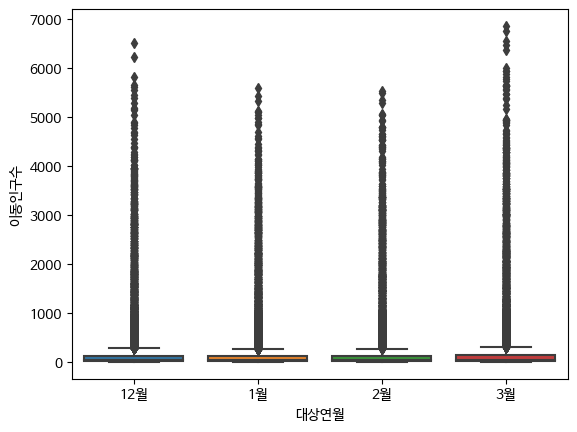

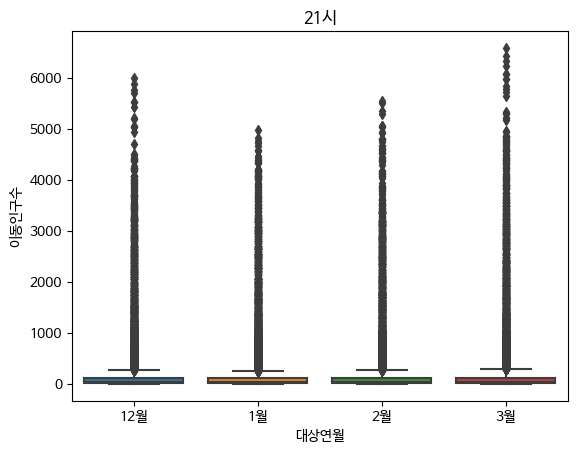

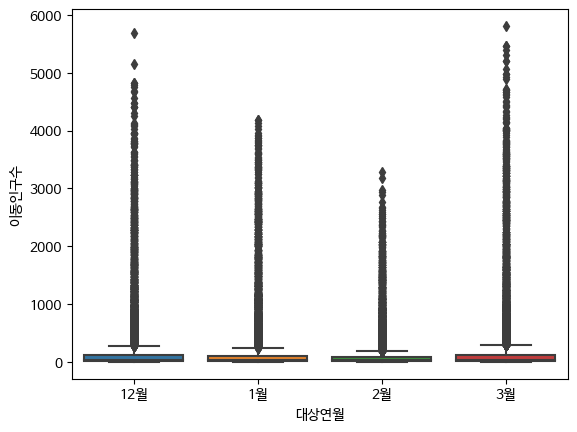

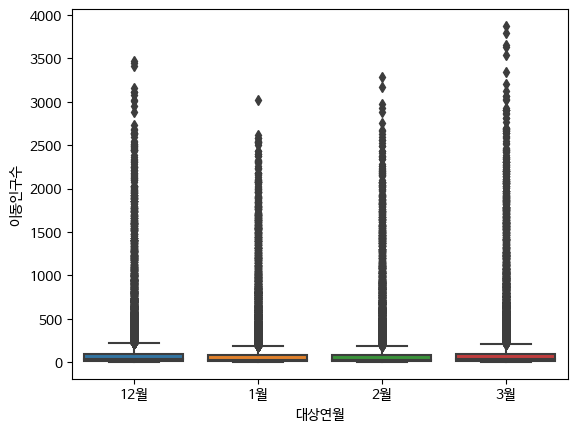

In [ ]:
for t in df['귀가시간대'].unique():
    data2 = df[df['귀가시간대']==t].copy()
    X = data2['대상연월']
    y = data2['이동인구수']

    sns.boxplot(x='대상연월', y='이동인구수', data=data2)
    plt.xticks([0,1,2,3], ['12월', '1월', '2월', '3월'])

    if t == 8:
        plt.title('21시')
    plt.show()

## 분산분석 가정 검정

In [ ]:
#정규성, 왜도 검정

for t in df['귀가시간대'].unique():
    data2 = df[df['귀가시간대']==t].copy()
    X = data2['대상연월']
    y = data2['이동인구수']

    print(f'{t}')
    print(stats.shapiro(X))
    print(stats.shapiro(y))
    print('skewness test of X : ', abs(stats.skew(X, bias=False)))
    print('skewness test of y : ', abs(stats.skew(y, bias=False)))

0
ShapiroResult(statistic=0.8542715311050415, pvalue=0.0)
ShapiroResult(statistic=0.3818818926811218, pvalue=0.0)
skewness test of X :  0.009584404373743796
skewness test of y :  5.925191907866315
1
ShapiroResult(statistic=0.8548799157142639, pvalue=0.0)
ShapiroResult(statistic=0.3659951686859131, pvalue=0.0)
skewness test of X :  0.010795994668704005
skewness test of y :  6.031703511715112
2
ShapiroResult(statistic=0.8545217514038086, pvalue=0.0)
ShapiroResult(statistic=0.36376744508743286, pvalue=0.0)
skewness test of X :  0.00862847212330062
skewness test of y :  6.504345477518223
3
ShapiroResult(statistic=0.853865385055542, pvalue=0.0)
ShapiroResult(statistic=0.38878268003463745, pvalue=0.0)
skewness test of X :  0.01961525408759396
skewness test of y :  6.173485281413374
4
ShapiroResult(statistic=0.8534103631973267, pvalue=0.0)
ShapiroResult(statistic=0.42229360342025757, pvalue=0.0)
skewness test of X :  0.011365467268971014
skewness test of y :  5.55999338825053
5
ShapiroResult(

In [ ]:
#등분산성 검정
for t in df['귀가시간대'].unique():
    data2 = df[df['귀가시간대']==t].copy()

    print(f'{t}')
    print(stats.levene((data2[data2['대상연월']==0]['이동인구수']), (data2[data2['대상연월']==1]['이동인구수']), (data2[data2['대상연월']==2]['이동인구수']), (data2[data2['대상연월']==3]['이동인구수'])))

0
LeveneResult(statistic=10.23291751453505, pvalue=9.86557710737371e-07)
1
LeveneResult(statistic=4.4412093044329355, pvalue=0.0039889283027249025)
2
LeveneResult(statistic=5.882083996259729, pvalue=0.0005209312915465233)
3
LeveneResult(statistic=5.592271582612028, pvalue=0.0007865192083009404)
4
LeveneResult(statistic=4.114995253945413, pvalue=0.006294694314079061)
5
LeveneResult(statistic=16.42530483889411, pvalue=1.1462068823006127e-10)
6
LeveneResult(statistic=18.425621252834627, pvalue=6.0383233186556135e-12)
7
LeveneResult(statistic=18.52834414760429, pvalue=5.191220672690351e-12)
8
LeveneResult(statistic=12.007450431280525, pvalue=7.431365989747232e-08)
9
LeveneResult(statistic=120.06000292126852, pvalue=1.3338957634095579e-77)
10
LeveneResult(statistic=16.820601725052, pvalue=6.416113739722434e-11)


In [ ]:
aov = {}
for t in df['귀가시간대'].unique():
    data = df[df['귀가시간대']==t].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in df['귀가시간대'].unique():
    data = df[df['귀가시간대']==t].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


###0시

In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.329030e+05,132903.029635,3.988646,0.045811
Residual,76212.0,2.539410e+09,33320.337826,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.2998,0.004,-11.0866,-1.5131,True
0,2,-4.8323,0.0487,-9.6459,-0.0188,True
0,3,3.4307,0.2523,-1.3465,8.208,False
1,2,1.4675,0.8634,-3.3635,6.2985,False
1,3,9.7306,0.0,4.9357,14.5254,True
2,3,8.2631,0.0001,3.4415,13.0847,True


###1시

In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.156472e+02,115.647236,0.007117,0.932767
Residual,63856.0,1.037582e+09,16248.775133,NaN,NaN


###2시

In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.593780e+03,4593.780068,0.481613,0.487695
Residual,54664.0,5.214026e+08,9538.317007,NaN,NaN


###3시

In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,5.472832e+03,5472.831684,1.05477,0.304416
Residual,48326.0,2.507466e+08,5188.647018,NaN,NaN


###4시

In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.871131e+03,2871.131179,0.723548,0.394987
Residual,45077.0,1.788712e+08,3968.125907,NaN,NaN


###18시

In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,7.985857e+06,7.985857e+06,24.607295,7.040213e-07
Residual,98321.0,3.190832e+10,3.245321e+05,NaN,NaN


In [ ]:
tukeyhsd[5]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-8.8745,0.3086,-22.0616,4.3127,False
0,2,-4.7255,0.7953,-17.9518,8.5008,False
0,3,25.3421,0.0,12.1751,38.509,True
1,2,4.1489,0.8519,-9.0839,17.3818,False
1,3,34.2165,0.0,21.043,47.3901,True
2,3,30.0676,0.0,16.8548,43.2804,True


###19시

In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.596491e+06,9.596491e+06,35.294095,2.844443e-09
Residual,97865.0,2.660957e+10,2.719008e+05,NaN,NaN


In [ ]:
tukeyhsd[6]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-4.4059,0.7866,-16.5261,7.7142,False
0,2,0.6867,0.9989,-11.4591,12.8326,False
0,3,27.5789,0.0,15.5153,39.6424,True
1,2,5.0927,0.7042,-7.0658,17.2512,False
1,3,31.9848,0.0,19.9085,44.0611,True
2,3,26.8921,0.0,14.7901,38.9942,True


###20시

In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,6.974096e+06,6.974096e+06,33.785493,6.173012e-09
Residual,95891.0,1.979409e+10,2.064228e+05,NaN,NaN


In [ ]:
tukeyhsd[7]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.2784,0.5818,-15.9517,5.3949,False
0,2,-0.2384,0.9999,-10.9248,10.448,False
0,3,23.5523,0.0,12.9258,34.1787,True
1,2,5.04,0.62,-5.6541,15.7341,False
1,3,28.8307,0.0,18.1965,39.4649,True
2,3,23.7907,0.0,13.1433,34.4381,True


###21시

In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.544540e+06,4.544540e+06,23.532513,0.000001
Residual,94792.0,1.830599e+10,1.931175e+05,NaN,NaN


In [ ]:
tukeyhsd[8]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-7.7916,0.2179,-18.1961,2.6128,False
0,2,5.5773,0.512,-4.8064,15.9611,False
0,3,16.1139,0.0004,5.7494,26.4784,True
1,2,13.369,0.0052,2.9912,23.7467,True
1,3,23.9055,0.0,13.547,34.2641,True
2,3,10.5366,0.0438,0.1988,20.8743,True


###22시

In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.687740e+02,168.774000,0.00126,0.97168
Residual,89658.0,1.200606e+10,133909.555897,NaN,NaN


###23시

In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.330299e+05,433029.856295,6.927822,0.008488
Residual,84941.0,5.309315e+09,62505.912026,NaN,NaN


In [ ]:
tukeyhsd[10]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-10.2586,0.0001,-16.4855,-4.0318,True
0,2,-7.8052,0.0072,-14.0504,-1.56,True
0,3,5.8395,0.0739,-0.367,12.0459,False
1,2,2.4534,0.7451,-3.8038,8.7106,False
1,3,16.0981,0.0,9.8795,22.3167,True
2,3,13.6447,0.0,7.4078,19.8816,True


# 분산분석: 지역별

In [ ]:
dfnew = df.copy()
dfnew['귀가시간대'] = dfnew['귀가시간대'].map({5: 0, 6: 1, 7: 2, 8: 3, 9: 4, 10: 5, 0: 6, 1: 7, 2: 8, 3: 9, 4: 10})

###노원구

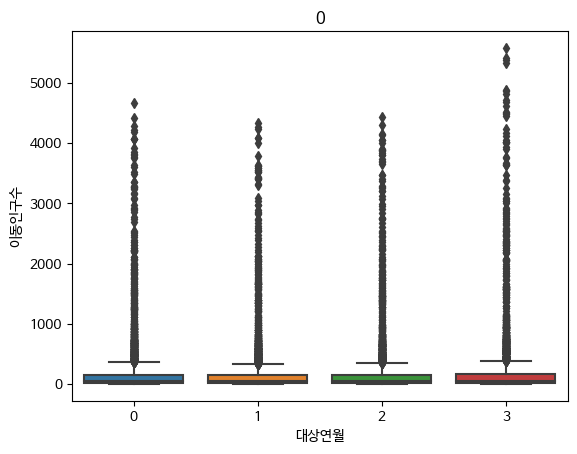

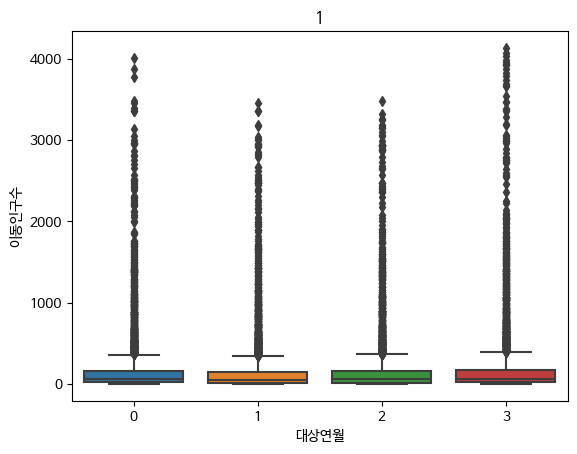

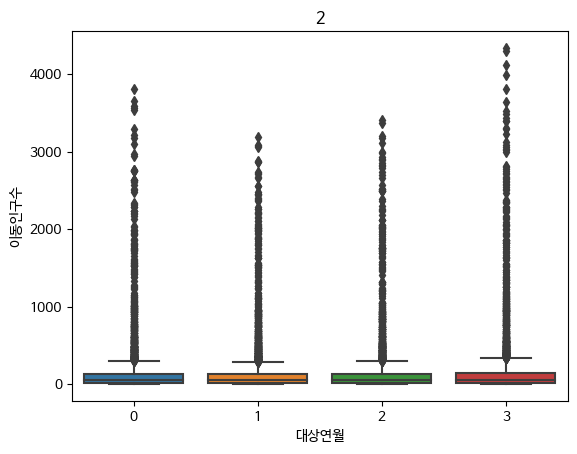

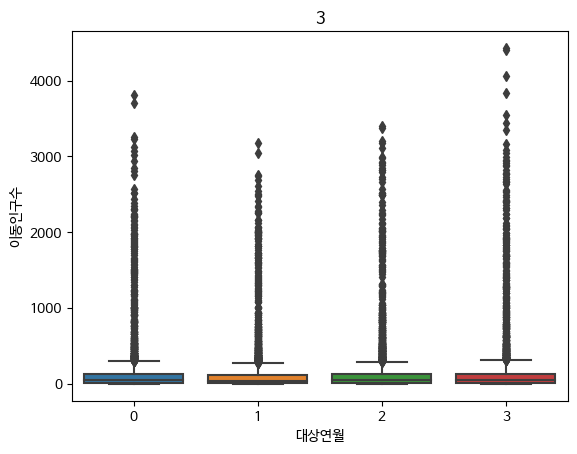

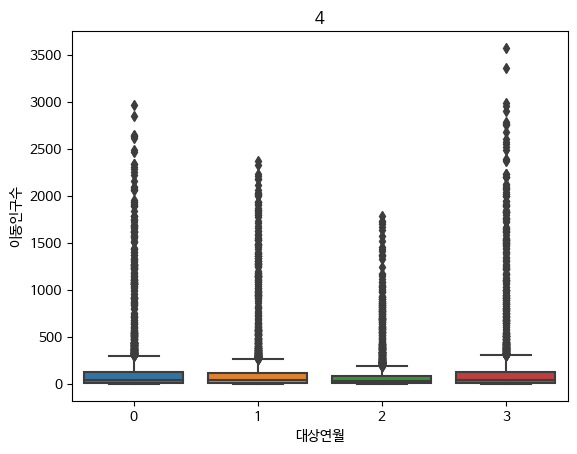

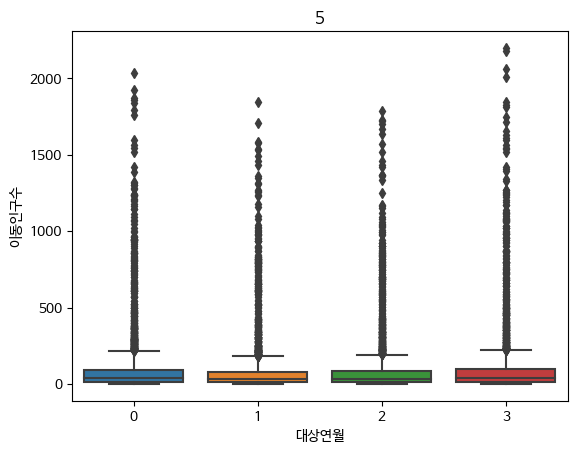

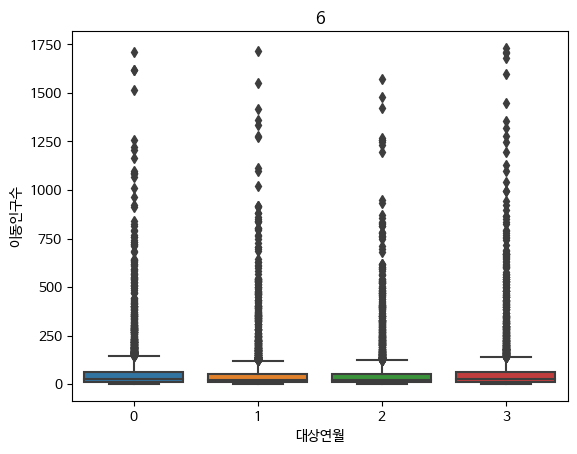

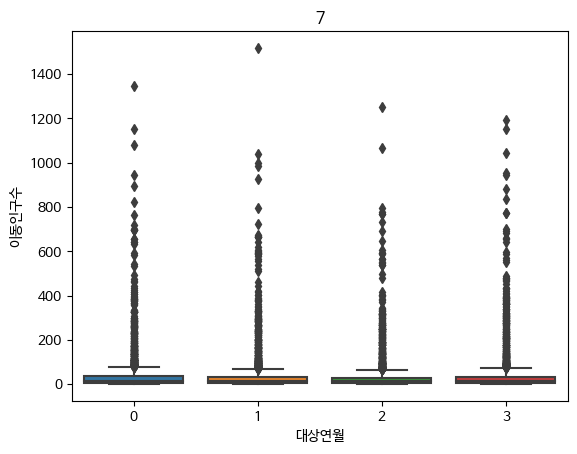

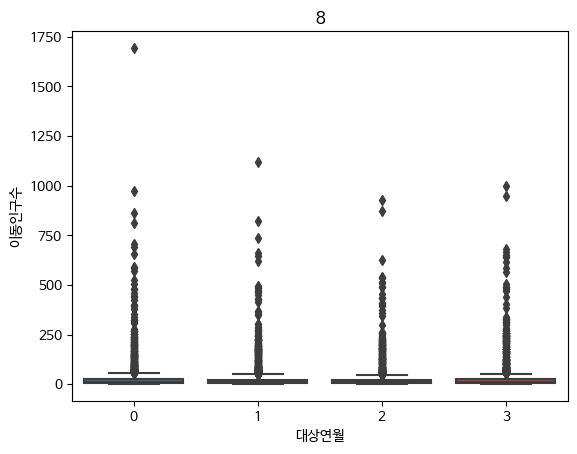

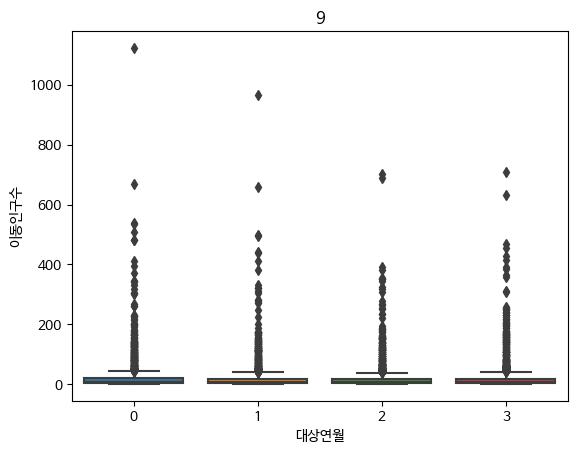

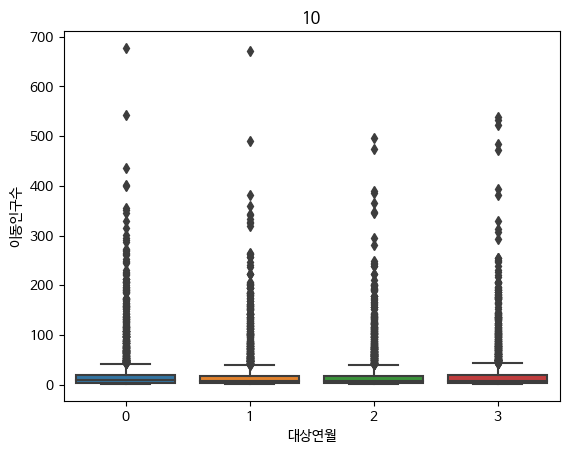

In [ ]:
for t in range(11):
    data8 = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==0)].copy()
    X = data8['대상연월']
    y = data8['이동인구수']
    sns.boxplot(x='대상연월', y='이동인구수', data=data8)
    plt.title(f'{t}')
    plt.show()

In [ ]:
aov = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==0)].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==0)].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.288390e+06,1.288390e+06,7.109211,0.007675
Residual,19858.0,3.598830e+09,1.812282e+05,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-11.0276,0.5684,-32.966,10.9107,False
0,2,-6.1847,0.8882,-28.1775,15.808,False
0,3,22.2757,0.0447,0.3538,44.1976,True
1,2,4.8429,0.9421,-17.13,26.8158,False
1,3,33.3034,0.0005,11.4013,55.2054,True
2,3,28.4604,0.0048,6.5039,50.4169,True


In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.459512e+06,1.459512e+06,10.566639,0.001153
Residual,20037.0,2.767600e+09,1.381245e+05,NaN,NaN


In [ ]:
tukeyhsd[1]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.9892,0.7827,-26.0716,12.0931,False
0,2,-1.6052,0.9965,-20.7407,17.5303,False
0,3,23.415,0.0084,4.4174,42.4126,True
1,2,5.384,0.8883,-13.7705,24.5385,False
1,3,30.4042,0.0002,11.3875,49.4209,True
2,3,25.0202,0.0042,5.9502,44.0902,True


In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.045277e+05,904527.728492,8.299764,0.003969
Residual,19351.0,2.108917e+09,108982.339476,NaN,NaN


In [ ]:
tukeyhsd[2]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-4.8962,0.8862,-22.1929,12.4006,False
0,2,-1.757,0.9937,-19.0104,15.4964,False
0,3,19.1824,0.0214,2.0075,36.3574,True
1,2,3.1392,0.9665,-14.1718,20.4501,False
1,3,24.0786,0.0019,6.8458,41.3114,True
2,3,20.9394,0.0095,3.7502,38.1287,True


In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,8.127998e+05,812799.785147,8.255471,0.004067
Residual,19111.0,1.881591e+09,98455.900630,NaN,NaN


In [ ]:
tukeyhsd[3]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.7783,0.7187,-23.331,9.7743,False
0,2,7.6261,0.634,-8.8561,24.1082,False
0,3,14.6222,0.1035,-1.8787,31.123,False
1,2,14.4044,0.1113,-2.0804,30.8892,False
1,3,21.4005,0.0048,4.897,37.904,True
2,3,6.9961,0.6933,-9.4367,23.4289,False


In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,6.004399e+01,60.043992,0.000965,0.975224
Residual,18071.0,1.124954e+09,62251.873884,NaN,NaN


In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,5.561601e+04,55616.010820,1.956388,0.161918
Residual,17297.0,4.917174e+08,28427.903113,NaN,NaN


In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.504473e+03,2504.473460,0.177636,0.673418
Residual,15702.0,2.213808e+08,14098.890723,NaN,NaN


In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,3.874635e+02,387.463480,0.061439,0.804239
Residual,13375.0,8.434863e+07,6306.439848,NaN,NaN


In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,8.284547e+02,828.454706,0.22307,0.63672
Residual,11364.0,4.220452e+07,3713.878723,NaN,NaN


In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.632282e+02,263.228184,0.130382,0.718044
Residual,9903.0,1.999323e+07,2018.905935,NaN,NaN


In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.302338e+03,1302.338341,0.682361,0.408797
Residual,9022.0,1.721918e+07,1908.577150,NaN,NaN


###강서구

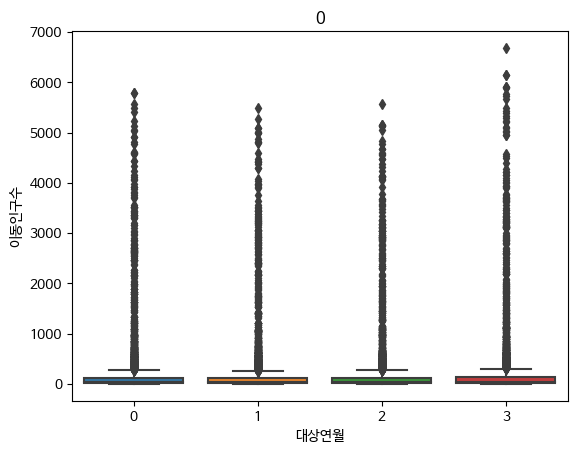

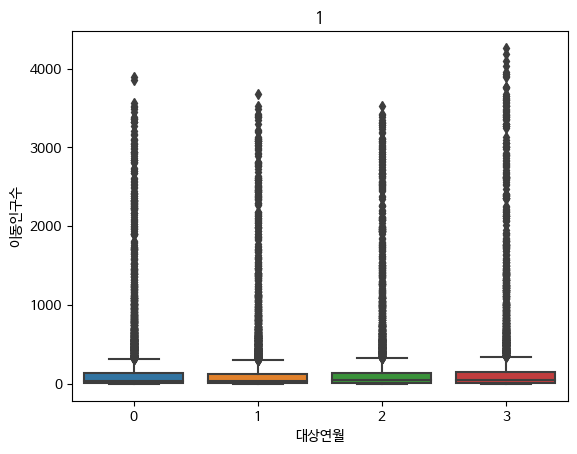

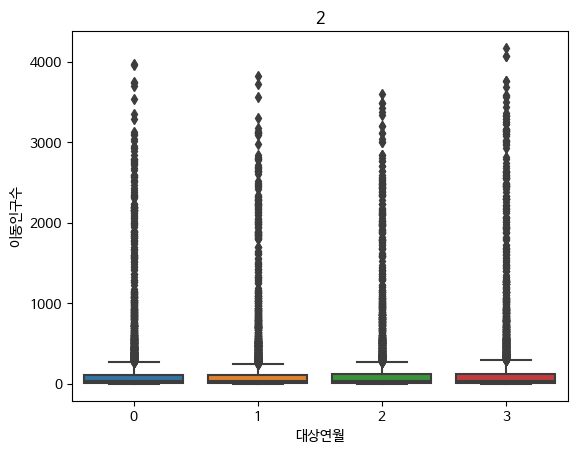

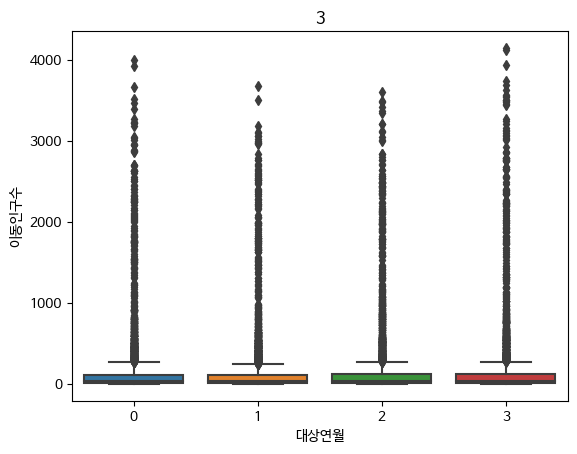

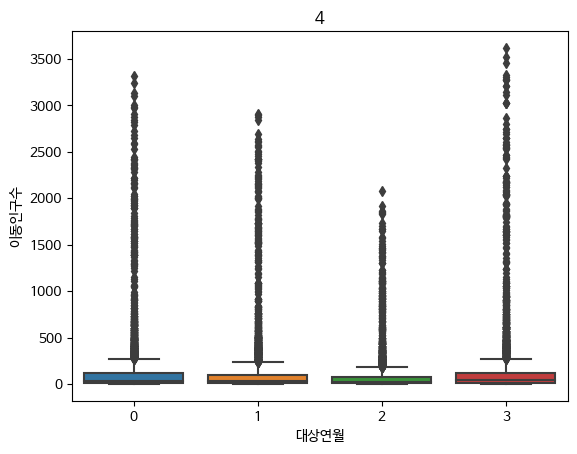

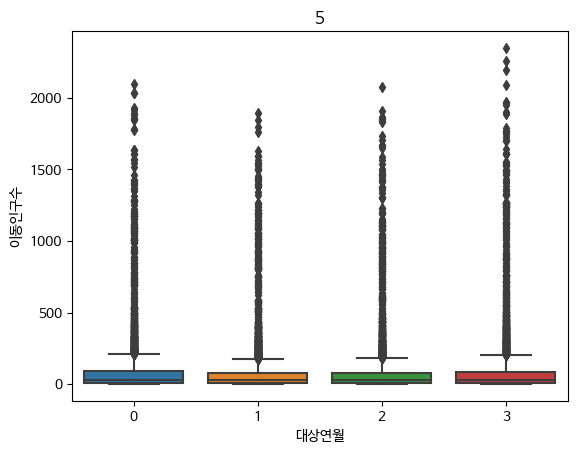

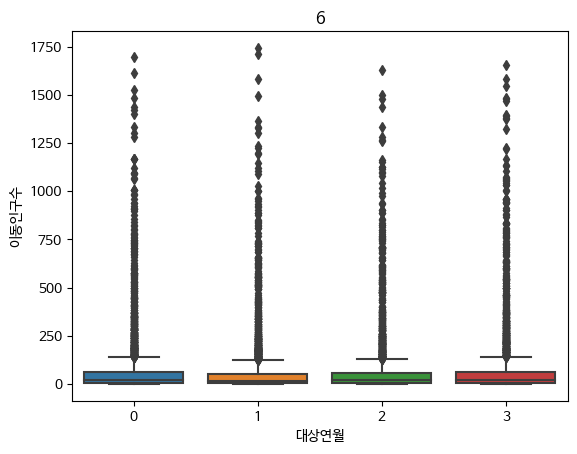

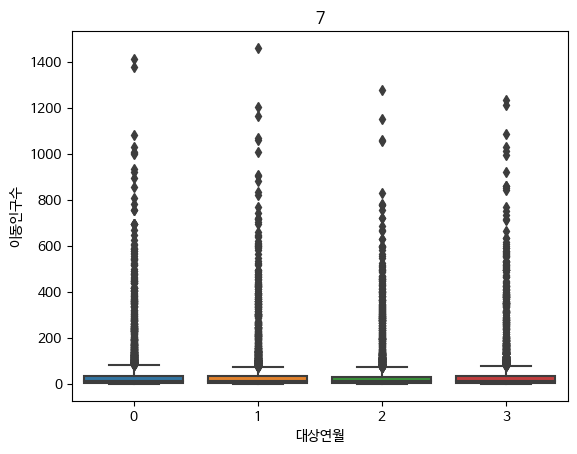

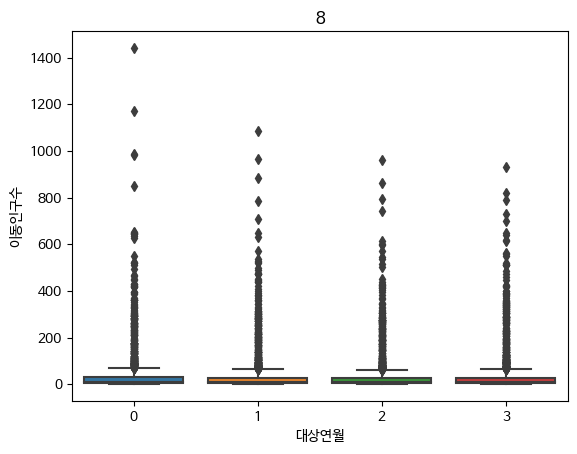

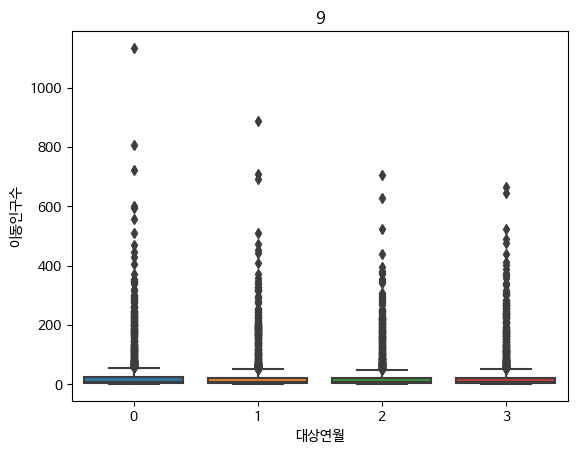

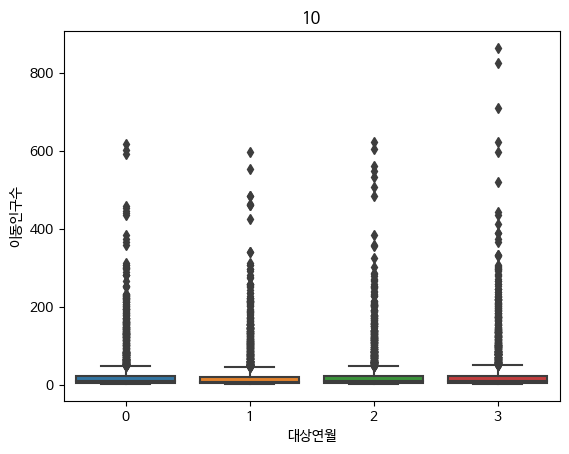

In [ ]:
for t in range(11):
    data8 = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==1)].copy()
    X = data8['대상연월']
    y = data8['이동인구수']
    sns.boxplot(x='대상연월', y='이동인구수', data=data8)
    plt.title(f'{t}')
    plt.show()

In [ ]:
aov = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==1)].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==1)].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.242570e+06,1.242570e+06,3.911089,0.047983
Residual,18850.0,5.988729e+09,3.177044e+05,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-8.2026,0.8941,-37.9809,21.5758,False
0,2,-3.5543,0.9902,-33.4972,26.3885,False
0,3,22.4701,0.2113,-7.2864,52.2266,False
1,2,4.6482,0.9784,-25.2586,34.555,False
1,3,30.6726,0.04,0.9524,60.3929,True
2,3,26.0244,0.1133,-3.8606,55.9094,False


In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.793713e+06,1.793713e+06,8.09872,0.004434
Residual,18875.0,4.180455e+09,2.214811e+05,NaN,NaN


In [ ]:
tukeyhsd[1]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-2.2576,0.9955,-27.1034,22.5882,False
0,2,3.8505,0.9789,-21.099,28.7999,False
0,3,26.8448,0.0275,2.0816,51.608,True
1,2,6.1081,0.9234,-18.9131,31.1293,False
1,3,29.1024,0.0139,4.267,53.9379,True
2,3,22.9943,0.0832,-1.9448,47.9334,False


In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.371598e+06,1.371598e+06,8.427741,0.0037
Residual,18464.0,3.004979e+09,1.627480e+05,NaN,NaN


In [ ]:
tukeyhsd[2]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-4.9229,0.9359,-26.4507,16.605,False
0,2,1.9418,0.9957,-19.6689,23.5525,False
0,3,23.3156,0.0274,1.8098,44.8213,True
1,2,6.8647,0.8474,-14.7749,28.5043,False
1,3,28.2385,0.0042,6.7037,49.7733,True
2,3,21.3738,0.054,-0.2438,42.9913,False


In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.422882e+05,942288.207530,6.167188,0.013023
Residual,18155.0,2.773913e+09,152790.568802,NaN,NaN


In [ ]:
tukeyhsd[3]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-3.5756,0.9724,-24.6865,17.5353,False
0,2,9.8919,0.6219,-11.1512,30.9349,False
0,3,16.9912,0.1616,-4.0542,38.0366,False
1,2,13.4675,0.3569,-7.6492,34.5841,False
1,3,20.5668,0.0596,-0.5521,41.6858,False
2,3,7.0993,0.8222,-13.9518,28.1505,False


In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.999737e+01,19.997366,0.000199,0.988737
Residual,17313.0,1.737295e+09,100346.272133,NaN,NaN


In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,5.267698e+04,52676.979712,1.174866,0.27842
Residual,16369.0,7.339299e+08,44836.577614,NaN,NaN


In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.139122e+04,21391.224054,0.948738,0.330057
Residual,14772.0,3.330647e+08,22547.030651,NaN,NaN


In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.580172e+02,158.017248,0.014301,0.904811
Residual,12169.0,1.344565e+08,11049.100771,NaN,NaN


In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,8.249015e+02,824.901503,0.131343,0.717051
Residual,10493.0,6.590144e+07,6280.514162,NaN,NaN


In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.192906e+03,2192.905577,0.631005,0.427008
Residual,9083.0,3.156579e+07,3475.259959,NaN,NaN


In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,5.215018e+03,5215.017899,1.636306,0.200869
Residual,8358.0,2.663751e+07,3187.067480,NaN,NaN


###관악구

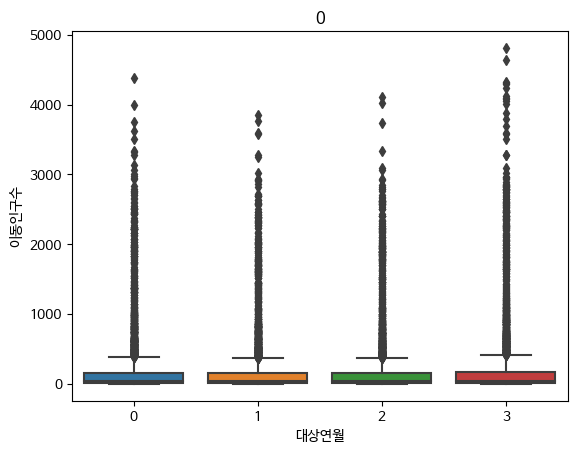

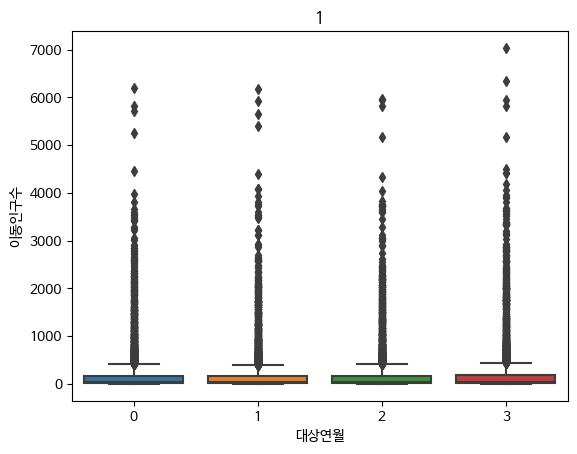

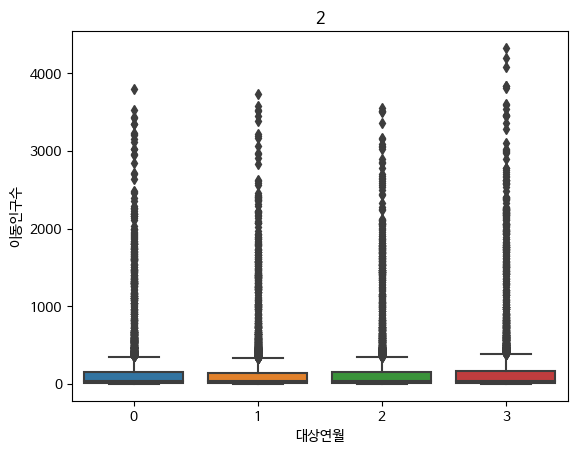

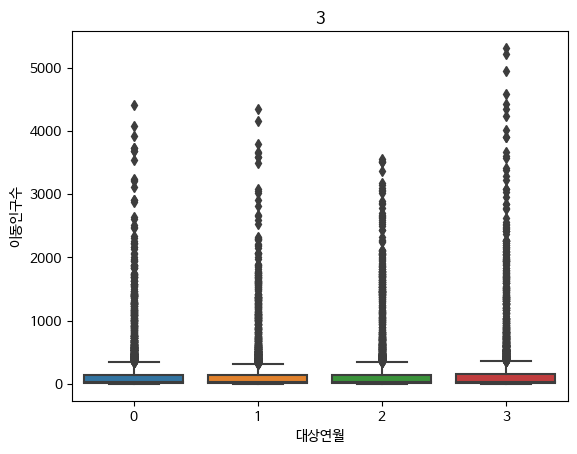

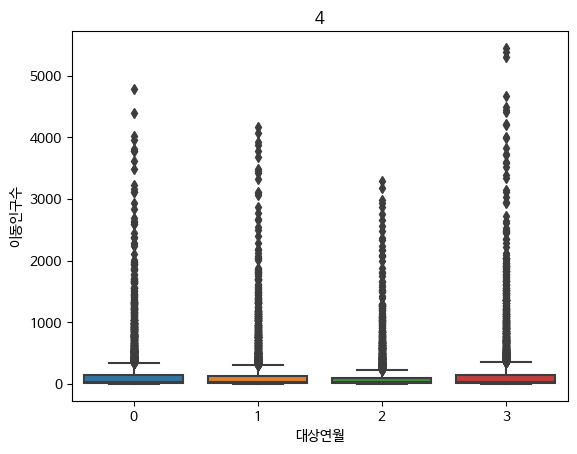

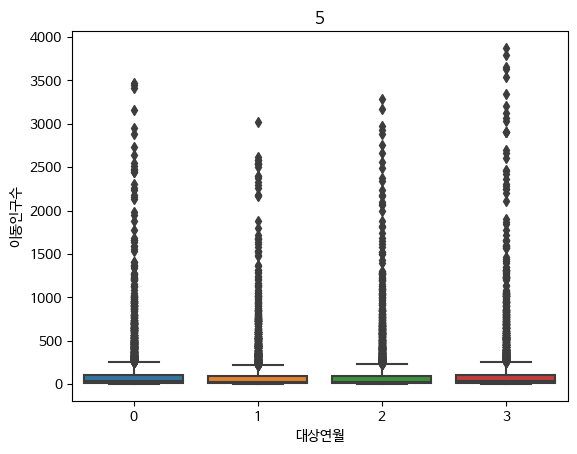

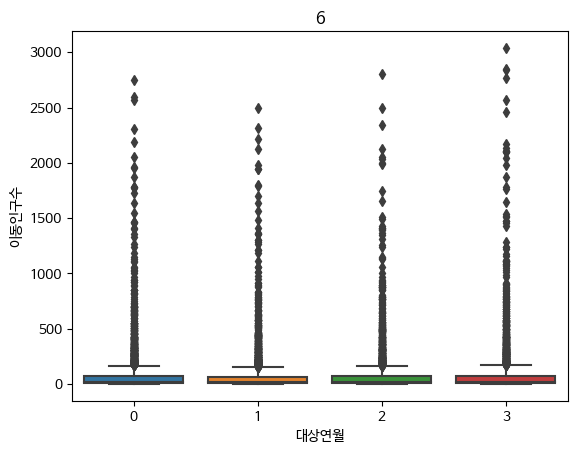

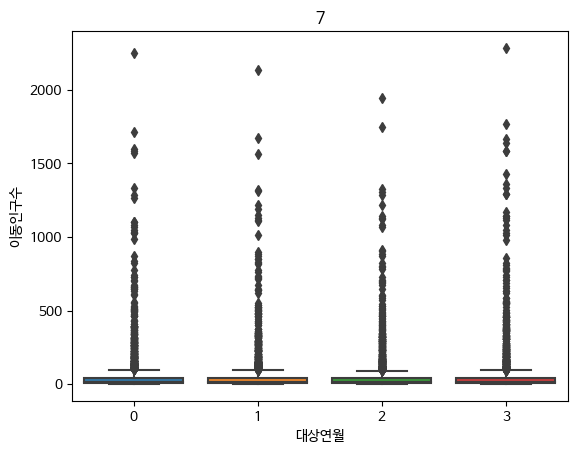

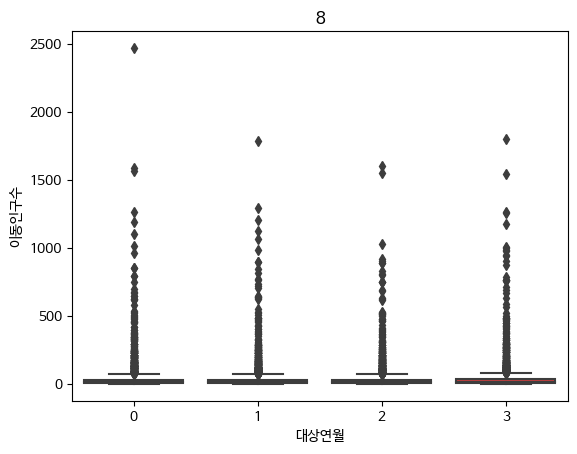

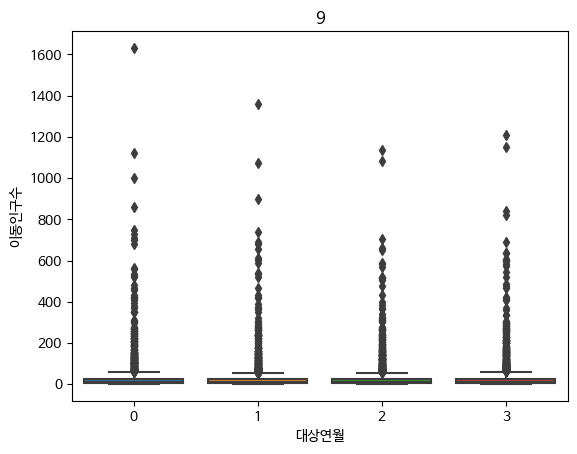

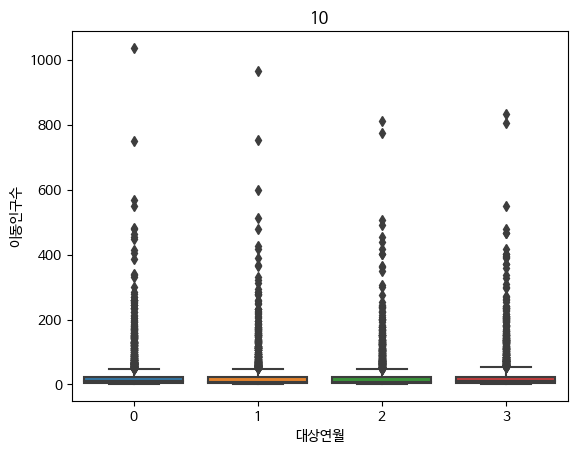

In [ ]:
for t in range(11):
    data8 = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==2)].copy()
    X = data8['대상연월']
    y = data8['이동인구수']
    sns.boxplot(x='대상연월', y='이동인구수', data=data8)
    plt.title(f'{t}')
    plt.show()

In [ ]:
aov = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==2)].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==2)].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.508554e+06,1.508554e+06,8.409313,0.003737
Residual,19637.0,3.522698e+09,1.793908e+05,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-9.201,0.7034,-31.1429,12.7409,False
0,2,-3.0869,0.984,-25.121,18.9473,False
0,3,23.8416,0.0261,1.9871,45.6961,True
1,2,6.1142,0.8924,-15.9521,28.1805,False
1,3,33.0426,0.0006,11.1557,54.9296,True
2,3,26.9285,0.0089,4.9491,48.9079,True


In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.625574e+06,1.625574e+06,7.798269,0.005235
Residual,19751.0,4.117158e+09,2.084531e+05,NaN,NaN


In [ ]:
tukeyhsd[1]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.7698,0.9236,-29.435,17.8953,False
0,2,-0.6564,0.9999,-24.3337,23.0208,False
0,3,25.0621,0.0314,1.5493,48.5748,True
1,2,5.1134,0.9454,-18.5855,28.8123,False
1,3,30.8319,0.0043,7.2974,54.3665,True
2,3,25.7185,0.0258,2.1718,49.2652,True


In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.259577e+06,1.259577e+06,9.015714,0.00268
Residual,19342.0,2.702252e+09,1.397090e+05,NaN,NaN


In [ ]:
tukeyhsd[2]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-5.7634,0.8739,-25.3364,13.8095,False
0,2,-0.5715,0.9998,-20.191,19.0479,False
0,3,22.0735,0.0191,2.5749,41.5722,True
1,2,5.1919,0.904,-14.3656,24.7494,False
1,3,27.837,0.0013,8.4007,47.2733,True
2,3,22.6451,0.015,3.1619,42.1283,True


In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.889257e+05,988925.685915,7.378209,0.006608
Residual,19020.0,2.549313e+09,134033.291980,NaN,NaN


In [ ]:
tukeyhsd[3]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-7.3202,0.7668,-26.7175,12.0772,False
0,2,3.7826,0.9584,-15.5401,23.1054,False
0,3,17.6772,0.0864,-1.6248,36.9791,False
1,2,11.1028,0.4498,-8.1754,30.381,False
1,3,24.9973,0.0047,5.74,44.2547,True
2,3,13.8945,0.245,-5.2876,33.0767,False


In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.691431e+04,46914.310343,0.407608,0.523194
Residual,17989.0,2.070474e+09,115096.659367,NaN,NaN


In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.916271e+05,191627.070751,2.786315,0.095091
Residual,17141.0,1.178862e+09,68774.380236,NaN,NaN


In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,6.846232e+04,68462.318553,1.87635,0.17077
Residual,15242.0,5.561344e+08,36486.969120,NaN,NaN


In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.910132e+03,1910.132313,0.118637,0.730523
Residual,12698.0,2.044459e+08,16100.639557,NaN,NaN


In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.300629e+00,2.300629,0.000221,0.988149
Residual,10940.0,1.140666e+08,10426.559123,NaN,NaN


In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.092725e+02,409.272467,0.076212,0.782503
Residual,9630.0,5.171466e+07,5370.161667,NaN,NaN


In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,3.325369e+02,332.536945,0.11374,0.735934
Residual,8753.0,2.559086e+07,2923.667133,NaN,NaN


###강남구

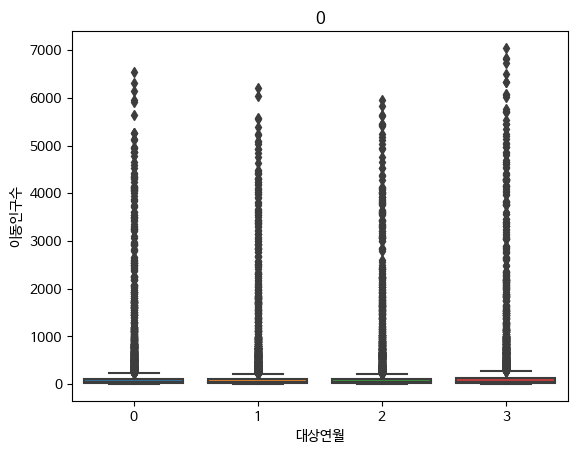

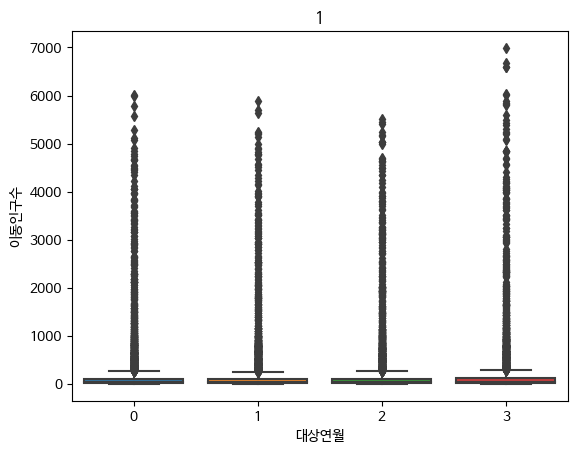

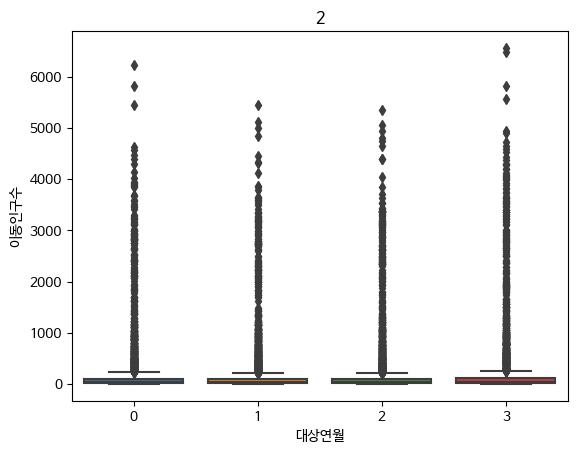

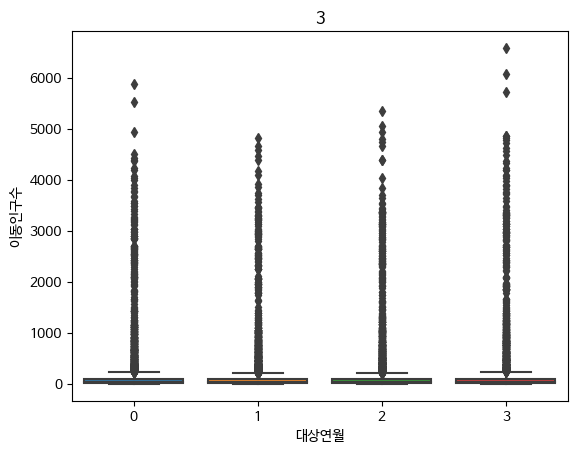

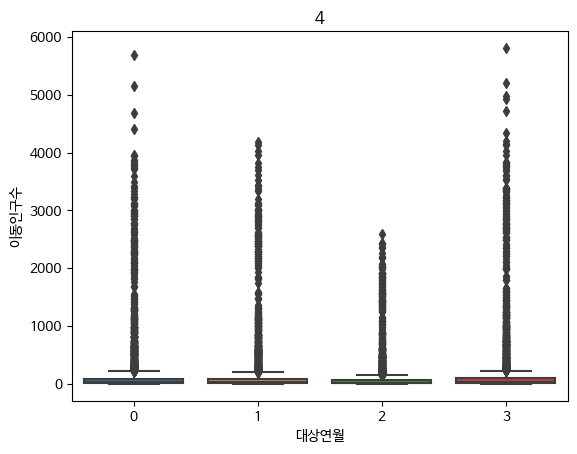

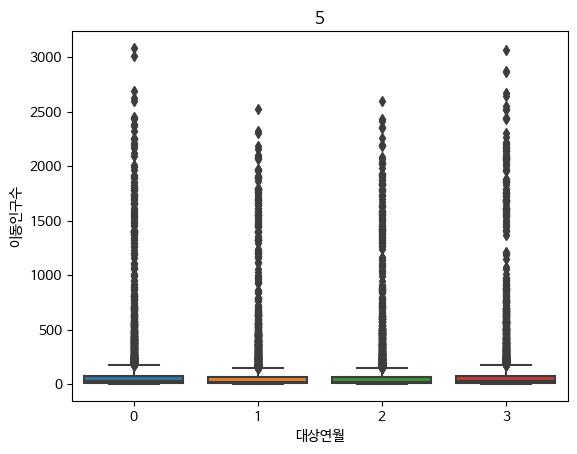

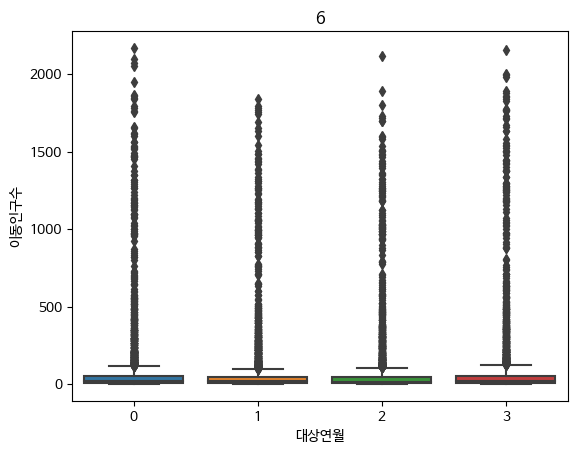

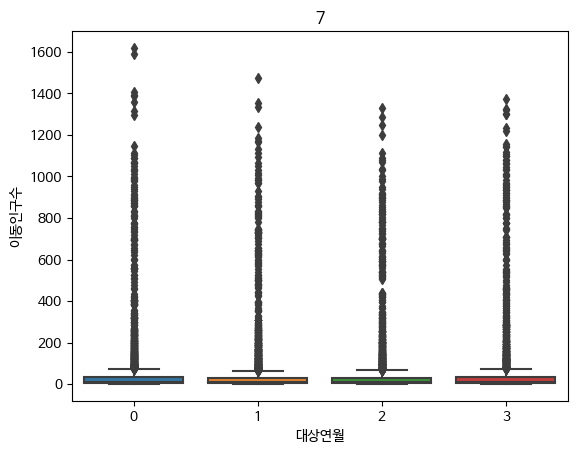

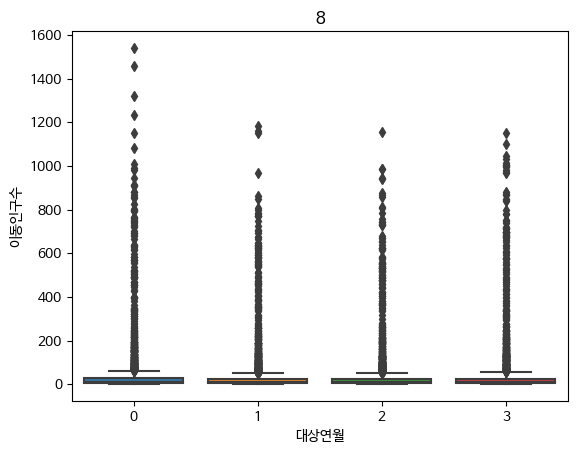

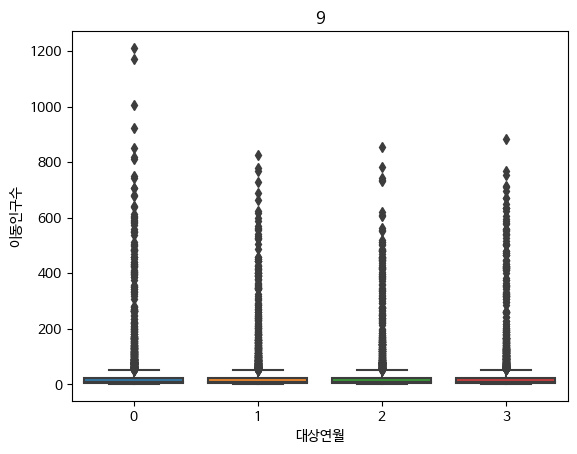

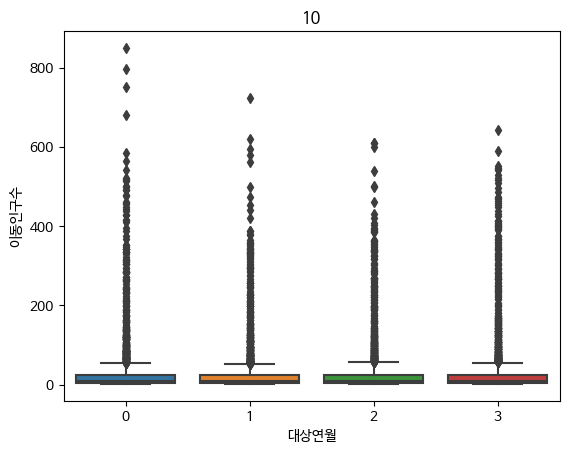

In [ ]:
for t in range(11):
    data8 = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==3)].copy()
    X = data8['대상연월']
    y = data8['이동인구수']
    sns.boxplot(x='대상연월', y='이동인구수', data=data8)
    plt.title(f'{t}')
    plt.show()

In [ ]:
aov = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==3)].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==3)].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.498731e+06,1.498731e+06,4.396897,0.036017
Residual,20354.0,6.937887e+09,3.408611e+05,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.3229,0.9475,-36.0526,23.4069,False
0,2,-5.7354,0.9601,-35.4769,24.0061,False
0,3,25.3369,0.1253,-4.3564,55.0301,False
1,2,0.5875,1.0,-29.1876,30.3625,False
1,3,31.6597,0.0316,1.9329,61.3865,True
2,3,31.0722,0.0366,1.3336,60.8108,True


In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.449690e+06,1.449690e+06,4.611024,0.031779
Residual,19870.0,6.247062e+09,3.143967e+05,NaN,NaN


In [ ]:
tukeyhsd[1]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-3.8836,0.9859,-32.8431,25.0758,False
0,2,0.3885,1.0,-28.6507,29.4276,False
0,3,23.7304,0.1471,-5.0461,52.5068,False
1,2,4.2721,0.9816,-24.7642,33.3083,False
1,3,27.614,0.0654,-1.1595,56.3875,False
2,3,23.3419,0.1602,-5.5118,52.1956,False


In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.458030e+06,1.458030e+06,6.007128,0.014257
Residual,19564.0,4.748507e+09,2.427166e+05,NaN,NaN


In [ ]:
tukeyhsd[2]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-4.8111,0.9629,-30.416,20.7938,False
0,2,-0.6217,0.9999,-26.2917,25.0482,False
0,3,24.1162,0.0715,-1.376,49.6084,False
1,2,4.1894,0.9753,-21.5067,29.8854,False
1,3,28.9273,0.0188,3.4088,54.4458,True
2,3,24.7379,0.0624,-0.8458,50.3217,False


In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.890573e+05,489057.329538,2.120973,0.14531
Residual,19449.0,4.484580e+09,230581.546249,NaN,NaN


In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.985353e+04,19853.529410,0.117271,0.732017
Residual,18265.0,3.092194e+09,169296.142663,NaN,NaN


In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.670711e+04,96707.105474,1.300183,0.254196
Residual,17058.0,1.268767e+09,74379.612584,NaN,NaN


In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.329905e+04,43299.05205,1.034053,0.309225
Residual,15241.0,6.381887e+08,41873.15229,NaN,NaN


In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,4.602770e-01,0.460277,0.000022,0.996263
Residual,12780.0,2.681420e+08,20981.379274,NaN,NaN


In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.868037e+03,2868.037152,0.213195,0.644284
Residual,11076.0,1.490017e+08,13452.665050,NaN,NaN


In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.105550e+03,2105.549704,0.27573,0.599525
Residual,10154.0,7.753884e+07,7636.284760,NaN,NaN


In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.664242e+03,1664.241585,0.370443,0.542776
Residual,10341.0,4.645773e+07,4492.576159,NaN,NaN


### 송파구

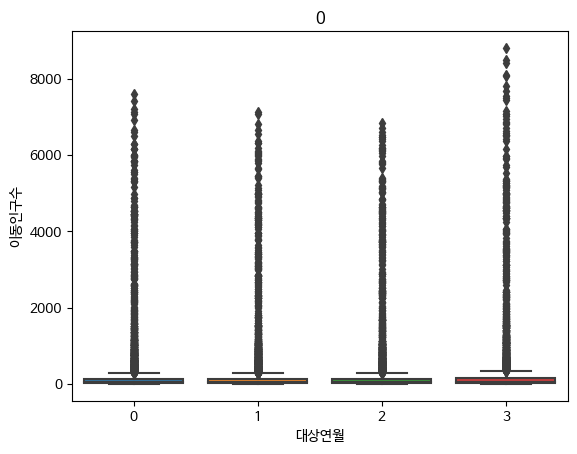

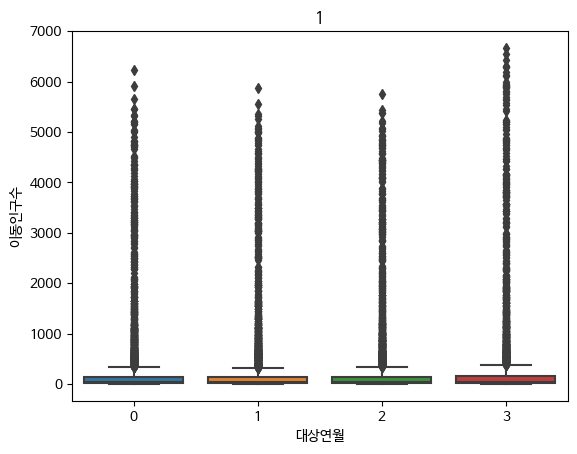

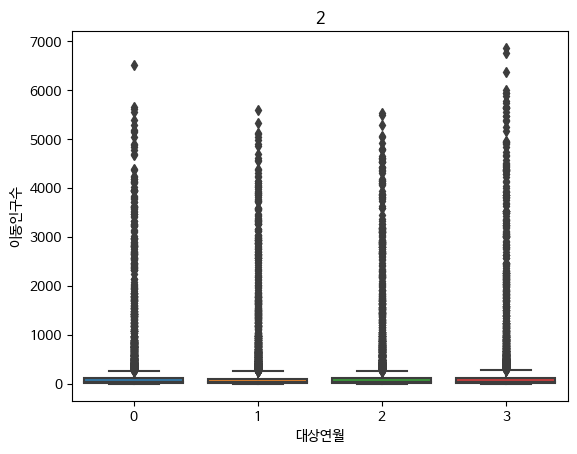

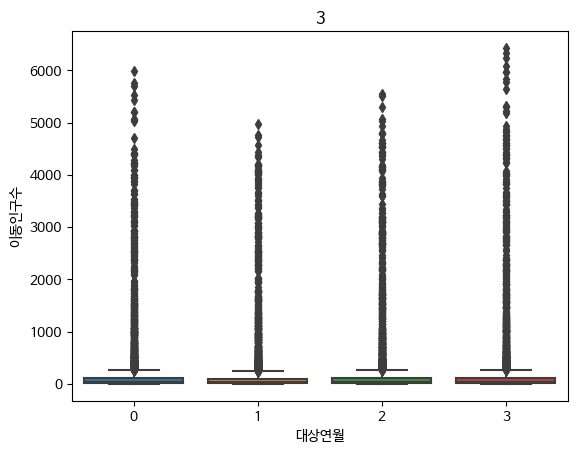

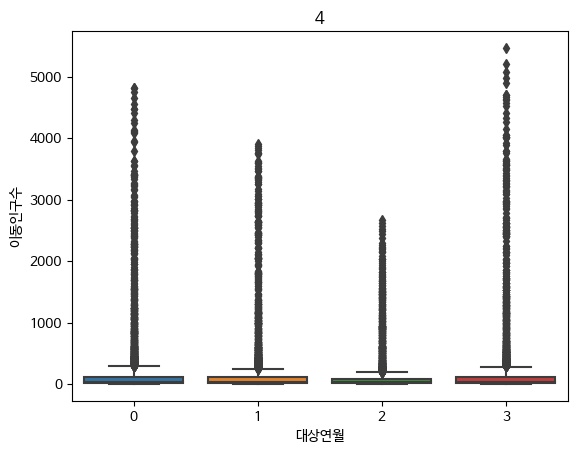

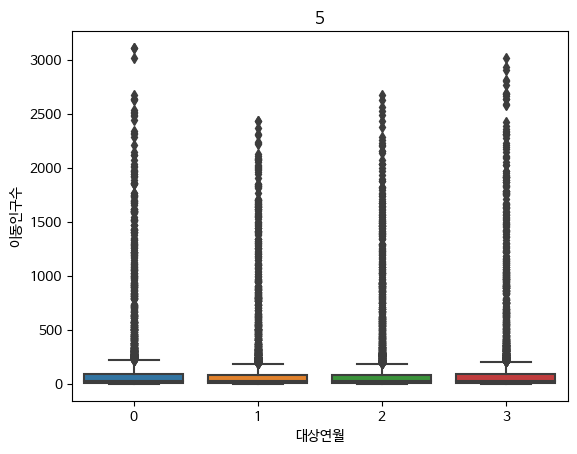

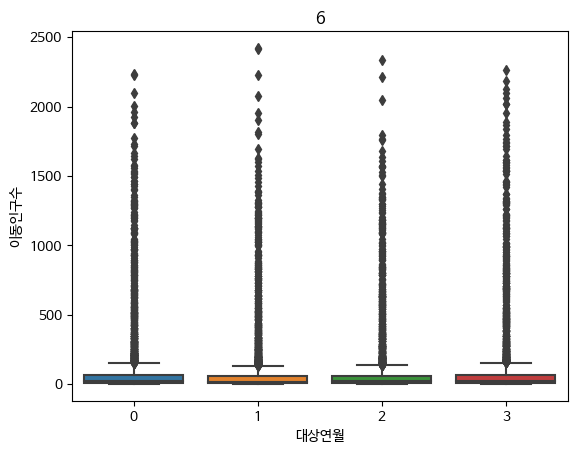

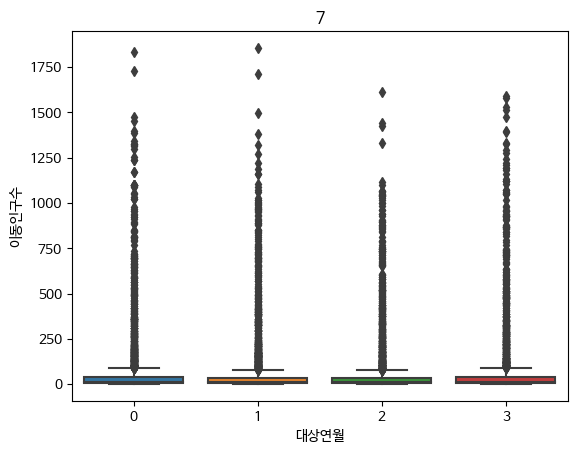

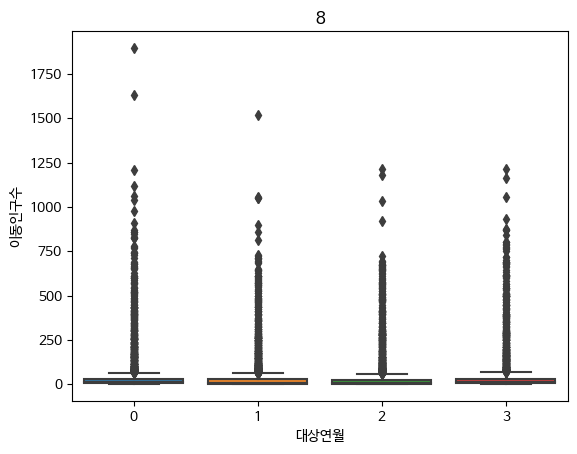

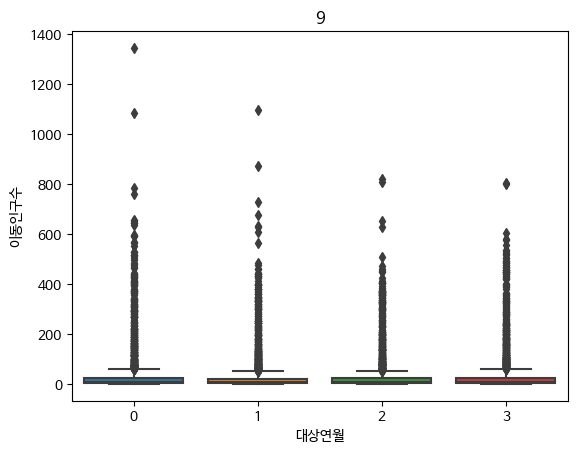

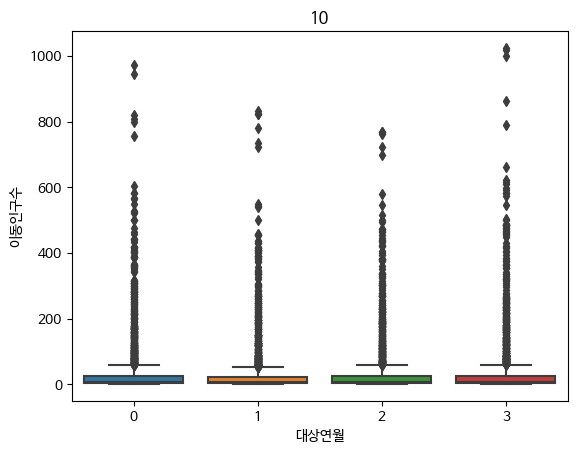

In [ ]:
for t in range(11):
    data8 = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==4)].copy()
    X = data8['대상연월']
    y = data8['이동인구수']
    sns.boxplot(x='대상연월', y='이동인구수', data=data8)
    plt.title(f'{t}')
    plt.show()

In [ ]:
aov = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==4)].copy()

    model = ols('이동인구수 ~ 대상연월', data).fit()
    print(f'{t}')
    aov[t] = anova_lm(model)

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
tukeyhsd = {}
for t in range(11):
    data = dfnew[(dfnew['귀가시간대']==t) & (dfnew['도착 시군구 코드']==4)].copy()

    comp = MultiComparison(data['이동인구수'], data['대상연월'])
    result = comp.tukeyhsd()
    print(f'{t}')
    tukeyhsd[t] = result.summary()

0
1
2
3
4
5
6
7
8
9
10


In [ ]:
aov[0]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.695041e+06,2.695041e+06,4.487196,0.034162
Residual,19614.0,1.178030e+10,6.006069e+05,NaN,NaN


In [ ]:
tukeyhsd[0]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-9.2677,0.9342,-49.4064,30.8711,False
0,2,-4.5731,0.9913,-44.8114,35.6651,False
0,3,33.2965,0.1426,-6.8054,73.3983,False
1,2,4.6945,0.9907,-35.6209,45.01,False
1,3,42.5641,0.0329,2.3848,82.7435,True
2,3,37.8696,0.0742,-2.4091,78.1483,False


In [ ]:
aov[1]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,3.683021e+06,3.683021e+06,7.709884,0.005497
Residual,19324.0,9.231099e+09,4.777012e+05,NaN,NaN


In [ ]:
tukeyhsd[1]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-3.059,0.9964,-39.2157,33.0977,False
0,2,1.1693,0.9998,-35.0044,37.3429,False
0,3,39.5738,0.0248,3.5138,75.6338,True
1,2,4.2283,0.9906,-31.966,40.4225,False
1,3,42.6328,0.0128,6.5522,78.7134,True
2,3,38.4045,0.0319,2.3069,74.5021,True


In [ ]:
aov[2]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.101264e+06,2.101264e+06,5.608904,0.017879
Residual,19162.0,7.178662e+09,3.746301e+05,NaN,NaN


In [ ]:
tukeyhsd[2]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-6.1265,0.9616,-38.3272,26.0742,False
0,2,-0.1065,1.0,-32.3072,32.0942,False
0,3,28.9595,0.0927,-3.0633,60.9823,False
1,2,6.02,0.9636,-26.2161,38.2562,False
1,3,35.086,0.0254,3.0276,67.1444,True
2,3,29.066,0.0914,-2.9924,61.1244,False


In [ ]:
aov[3]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.441789e+06,1.441789e+06,4.181512,0.040881
Residual,19049.0,6.568112e+09,3.448009e+05,NaN,NaN


In [ ]:
tukeyhsd[3]

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,-11.2457,0.7876,-42.2414,19.7499,False
0,2,7.1742,0.9336,-23.797,38.1455,False
0,3,19.6914,0.357,-11.1883,50.5711,False
1,2,18.4199,0.42,-12.5316,49.3715,False
1,3,30.9371,0.0492,0.0771,61.7972,True
2,3,12.5172,0.7241,-18.3183,43.3527,False


In [ ]:
aov[4]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.001546e+04,10015.463317,0.045688,0.830747
Residual,18012.0,3.948510e+09,219215.509302,NaN,NaN


In [ ]:
aov[5]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,6.073236e+04,60732.356865,0.63965,0.423849
Residual,17068.0,1.620542e+09,94946.213973,NaN,NaN


In [ ]:
aov[6]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,2.271167e+04,22711.666758,0.4432,0.505592
Residual,15247.0,7.813286e+08,51244.742593,NaN,NaN


In [ ]:
aov[7]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,3.573219e+02,357.321896,0.013439,0.907713
Residual,12826.0,3.410273e+08,26588.745679,NaN,NaN


In [ ]:
aov[8]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,1.830310e+03,1830.309983,0.133937,0.714392
Residual,10783.0,1.473551e+08,13665.497021,NaN,NaN


In [ ]:
aov[9]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,9.820188e+02,982.018822,0.137372,0.710916
Residual,9548.0,6.825474e+07,7148.590718,NaN,NaN


In [ ]:
aov[10]

,df,sum_sq,mean_sq,F,PR(>F)
대상연월,1.0,6.694927e+02,669.492719,0.093128,0.760245
Residual,8595.0,6.178914e+07,7188.963267,NaN,NaN


#회귀분석
- 각 월별 귀가시간에 따른 인구 변화를 살펴보자

In [ ]:
dfnew

,귀가시간대,대상연월,요일,출발 시군구 코드,도착 시군구 코드,성별,나이대,이동유형,이동인구수,이동인구수_log
0,6,0,4,0,0,1,0,0,225.18,5.416900
1,6,0,4,0,0,1,0,1,1.50,0.405465
2,6,0,4,0,0,1,0,2,175.66,5.168550
3,6,0,4,0,0,1,1,0,91.37,4.514917
4,6,0,4,0,0,1,1,2,79.61,4.377140
...,...,...,...,...,...,...,...,...,...,...
849620,5,3,1,24,4,0,4,1,3.52,1.258461
849621,5,3,1,24,4,0,4,2,137.66,4.924787
849622,5,3,1,24,4,0,5,0,72.09,4.277915
849623,5,3,1,24,4,0,5,2,42.98,3.760735


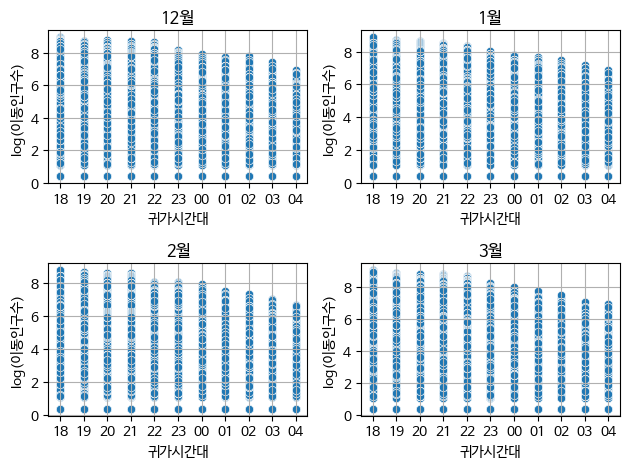

In [ ]:
for month in range(4):
    datamonth = dfnew[dfnew['대상연월']==month]
    plt.subplot(2,2,month+1)
    sns.scatterplot(x='귀가시간대', y='이동인구수_log', data=datamonth)
    plt.ylabel('log(이동인구수)')
    plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], ['18', '19', '20', '21', '22', '23', '00', '01', '02', '03', '04'])
    plt.grid(True)

    if month == 0:
        plt.title('12월')
    elif month == 1:
        plt.title('1월')
    elif month == 2:
        plt.title('2월')
    else:
        plt.title('3월')

plt.tight_layout()
plt.show()

###12월

In [ ]:
X = dfnew[dfnew['대상연월']==0]['귀가시간대']
y = dfnew[dfnew['대상연월']==0]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5942.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:34:17   Log-Likelihood:            -1.5676e+06
No. Observations:              214128   AIC:                         3.135e+06
Df Residuals:                  214126   BIC:                         3.135e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        212.4570      1.372    154.825      0.0

###1월

In [ ]:
X = dfnew[dfnew['대상연월']==1]['귀가시간대']
y = dfnew[dfnew['대상연월']==1]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5998.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:34:37   Log-Likelihood:            -1.5478e+06
No. Observations:              212385   AIC:                         3.096e+06
Df Residuals:                  212383   BIC:                         3.096e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        204.1768      1.330    153.460      0.0

###2월

In [ ]:
X = dfnew[dfnew['대상연월']==2]['귀가시간대']
y = dfnew[dfnew['대상연월']==2]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6389.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:35:02   Log-Likelihood:            -1.5140e+06
No. Observations:              207935   AIC:                         3.028e+06
Df Residuals:                  207933   BIC:                         3.028e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        206.2630      1.331    155.000      0.0

###3월

In [ ]:
X = dfnew[dfnew['대상연월']==3]['귀가시간대']
y = dfnew[dfnew['대상연월']==3]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     6174.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:35:24   Log-Likelihood:            -1.6041e+06
No. Observations:              215177   AIC:                         3.208e+06
Df Residuals:                  215175   BIC:                         3.208e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        239.5286      1.562    153.357      0.0

#회귀분석: 도착지 추가

###도착지: 노원구(0)

In [ ]:
X = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==0)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==0)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1936.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:28:22   Log-Likelihood:            -3.0470e+05
No. Observations:               43647   AIC:                         6.094e+05
Df Residuals:                   43645   BIC:                         6.094e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        182.3294      2.170     84.032      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==0)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==0)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     1934.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:28:41   Log-Likelihood:            -2.9974e+05
No. Observations:               43242   AIC:                         5.995e+05
Df Residuals:                   43240   BIC:                         5.995e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        172.8555      2.071     83.456      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==0)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==0)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     2006.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:28:59   Log-Likelihood:            -2.9503e+05
No. Observations:               42452   AIC:                         5.901e+05
Df Residuals:                   42450   BIC:                         5.901e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        176.1844      2.119     83.129      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==0)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==0)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1910.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:29:21   Log-Likelihood:            -3.1240e+05
No. Observations:               43772   AIC:                         6.248e+05
Df Residuals:                   43770   BIC:                         6.248e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.5892      2.526     81.378      0.0

###도착지: 강서구(1)

In [ ]:
X = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==1)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==1)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1321.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          8.50e-285
Time:                        07:29:45   Log-Likelihood:            -2.9804e+05
No. Observations:               41217   AIC:                         5.961e+05
Df Residuals:                   41215   BIC:                         5.961e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.2092      2.858     71.789      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==1)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==1)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1305.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          2.18e-281
Time:                        07:30:03   Log-Likelihood:            -2.9393e+05
No. Observations:               40771   AIC:                         5.879e+05
Df Residuals:                   40769   BIC:                         5.879e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        198.5739      2.807     70.752      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==1)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==1)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1423.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          6.69e-306
Time:                        07:30:21   Log-Likelihood:            -2.8623e+05
No. Observations:               39771   AIC:                         5.725e+05
Df Residuals:                   39769   BIC:                         5.725e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        201.9087      2.799     72.149      0.0

In [ ]:
np.exp(0.1751)

1.191365347190449

In [ ]:
X = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==1)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==1)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1375.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.65e-296
Time:                        07:30:44   Log-Likelihood:            -3.0280e+05
No. Observations:               41164   AIC:                         6.056e+05
Df Residuals:                   41162   BIC:                         6.056e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        230.8648      3.235     71.357      0.0

In [ ]:
np.exp(0.1781)

1.19494480974125

###도착지: 관악구(2)

In [ ]:
X = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1475.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          3.42e-317
Time:                        07:30:59   Log-Likelihood:            -3.0473e+05
No. Observations:               42632   AIC:                         6.095e+05
Df Residuals:                   42630   BIC:                         6.095e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.6045      2.584     79.583      0.0

In [ ]:
np.exp(0.1636)

1.1777431236112639

In [ ]:
X = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1464.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          4.80e-315
Time:                        07:31:13   Log-Likelihood:            -3.0242e+05
No. Observations:               42489   AIC:                         6.048e+05
Df Residuals:                   42487   BIC:                         6.049e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        196.4631      2.510     78.283      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1579.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:31:29   Log-Likelihood:            -2.9685e+05
No. Observations:               41729   AIC:                         5.937e+05
Df Residuals:                   41727   BIC:                         5.937e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.6659      2.514     79.416      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1473.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          5.32e-317
Time:                        07:31:40   Log-Likelihood:            -3.1636e+05
No. Observations:               43315   AIC:                         6.327e+05
Df Residuals:                   43313   BIC:                         6.327e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        231.8221      2.992     77.486      0.0

###도착지: 강남구(3)

In [ ]:
X = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==3)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==3)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     914.2
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          9.01e-199
Time:                        07:32:03   Log-Likelihood:            -3.2458e+05
No. Observations:               43860   AIC:                         6.492e+05
Df Residuals:                   43858   BIC:                         6.492e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        205.4399      3.272     62.780      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1464.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          4.80e-315
Time:                        07:32:13   Log-Likelihood:            -3.0242e+05
No. Observations:               42489   AIC:                         6.048e+05
Df Residuals:                   42487   BIC:                         6.049e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        196.4631      2.510     78.283      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1579.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        07:32:24   Log-Likelihood:            -2.9685e+05
No. Observations:               41729   AIC:                         5.937e+05
Df Residuals:                   41727   BIC:                         5.937e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.6659      2.514     79.416      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==2)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==2)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     1473.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          5.32e-317
Time:                        07:32:39   Log-Likelihood:            -3.1636e+05
No. Observations:               43315   AIC:                         6.327e+05
Df Residuals:                   43313   BIC:                         6.327e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        231.8221      2.992     77.486      0.0

###도착지: 송파구(4)

In [ ]:
X = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==4)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==0) & (dfnew['도착 시군구 코드']==4)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1036.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.05e-224
Time:                        07:33:25   Log-Likelihood:            -3.2528e+05
No. Observations:               42772   AIC:                         6.506e+05
Df Residuals:                   42770   BIC:                         6.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        264.1276      4.085     64.658      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==4)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==1) & (dfnew['도착 시군구 코드']==4)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          2.66e-229
Time:                        07:26:26   Log-Likelihood:            -3.1989e+05
No. Observations:               42238   AIC:                         6.398e+05
Df Residuals:                   42236   BIC:                         6.398e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        255.4107      3.976     64.243      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==4)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==2) & (dfnew['도착 시군구 코드']==4)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1134.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          2.71e-245
Time:                        07:27:39   Log-Likelihood:            -3.1457e+05
No. Observations:               41580   AIC:                         6.291e+05
Df Residuals:                   41578   BIC:                         6.292e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.9231      3.961     64.868      0.0

In [ ]:
X = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==4)]['귀가시간대']
y = dfnew[(dfnew['대상연월']==3) & (dfnew['도착 시군구 코드']==4)]['이동인구수']

X_with_intercept = sm.add_constant(X)

# 모델 생성 및 학습
model = sm.OLS(y, X_with_intercept)
results = model.fit()

# 모델 요약 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  이동인구수   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 14 Aug 2023   Prob (F-statistic):          1.44e-234
Time:                        07:27:59   Log-Likelihood:            -3.3022e+05
No. Observations:               42660   AIC:                         6.604e+05
Df Residuals:                   42658   BIC:                         6.605e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        299.5600      4.672     64.112      0.0